# Imports

In [3]:
%load_ext autoreload
%autoreload 2

import sys 
import glob
import ray
import logging 
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import xarray as xr
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import medfilt
from pathlib import Path
from scipy.optimize import minimize_scalar
from scipy.stats import binned_statistic

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from kornia.geometry.transform import Affine
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import *
from models import *
from fit_GLM_Network import *
pd.set_option('display.max_rows', None)

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/h5py/__init__.py:46: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  from ._conv import register_converters as _register_converters


{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:6379',
 'object_store_address': '/tmp/ray/session_2021-11-26_10-07-31_826246_51826/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-11-26_10-07-31_826246_51826/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-11-26_10-07-31_826246_51826',
 'metrics_export_port': 49876,
 'node_id': 'b8ba3e852730717adbaf2ade33e5662532e222ef3cbdd368e29b8a19'}

In [4]:
dataset_type = 'test'
def load_Kfold_forPlots(params, Kfold=0, dataset_type='test',thresh_fr = 1, tuning_thresh = .2):
    params['do_norm']=False
    data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)
    train_idx = train_idx_list[Kfold]
    test_idx = test_idx_list[Kfold]
    data = load_Kfold_data(data,train_idx,test_idx,params)
    locals().update(data)
    locals().update(params)

    avgfm_eye = np.load(save_dir_fm/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
    if params['free_move']:
        move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1],data['train_roll'][:, np.newaxis], data['train_pitch'][:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1],data['test_roll'][:, np.newaxis], data['test_pitch'][:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1],data['model_roll'][:, np.newaxis], data['model_pitch'][:, np.newaxis]))
        model_move = (model_move - np.nanmean(model_move,axis=0))
        move_test = model_move[test_idx]
        move_train = model_move[train_idx]
    else:
        move_train = np.hstack((data['train_th'][:, np.newaxis]-avgfm_eye[0], data['train_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['train_phi'].shape)[:, np.newaxis], np.zeros(data['train_phi'].shape)[:, np.newaxis]))
        move_test = np.hstack((data['test_th'][:, np.newaxis]-avgfm_eye[0], data['test_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['test_phi'].shape)[:, np.newaxis], np.zeros(data['test_phi'].shape)[:, np.newaxis]))
        model_move = np.hstack((data['model_th'][:, np.newaxis]-avgfm_eye[0], data['model_phi'][:, np.newaxis]-avgfm_eye[1], np.zeros(data['model_phi'].shape)[:, np.newaxis], np.zeros(data['model_phi'].shape)[:, np.newaxis]))
    
    if dataset_type == 'train':
        nsp_raw = data['train_nsp']
        move_data = move_train.copy()
    else: 
        nsp_raw = data['test_nsp']
        move_data = move_test.copy()
        
    if params['free_move']:
        spk_percentile2 = np.arange(.125,1.125,.25)
        quartiles = np.arange(0,1.25,.25)
        tuning_curves = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
        tuning_stds = np.zeros((model_nsp.shape[1],len(titles),1))
        tuning_curve_edges = np.zeros((model_nsp.shape[1],len(titles),len(quartiles)-1))
        ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
        for i,modeln in enumerate(range(len(titles))):
            for celln in np.arange(model_nsp.shape[1]):
                metric = move_data[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
                stat_std, _, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='std',bins=nranges)
                tuning_curves[celln,modeln] = stat_range/params['model_dt']
                edge_mids = np.quantile(metric,spk_percentile2)
                tuning_curve_edges[celln,modeln] = edge_mids
                tuning_stds[celln,modeln] = stat_std.max()
            ax_ylims[:,modeln] = np.nanmax(tuning_curves[:,modeln],axis=-1)
        tc_mod = (np.max(tuning_curves,axis=-1,keepdims=True)-np.min(tuning_curves,axis=-1,keepdims=True))/(np.max(tuning_curves,axis=-1,keepdims=True)+np.min(tuning_curves,axis=-1,keepdims=True))
        avg_fr = np.mean(tuning_curves,axis=(-1,-2)).squeeze()

        tuning_sig = tc_mod.copy()
        tuning_sig[avg_fr<thresh_fr,:,0] = np.nan
        tuning_sig2 = np.any(tuning_sig>tuning_thresh,axis=1).squeeze()
        tuning_idx = np.where(tuning_sig2)[0]
    else: 
        tuning_curves=tuning_stds=tuning_curve_edges=ax_ylims=tc_mod=avg_fr=tuning_sig=tuning_sig2=tuning_idx = None
    return move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx
# move_train,move_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=2, dataset_type='test')

# Hidden Layer Vis Training

In [ ]:
args = arg_parser(jupyter=True)

MovModel = 1
LinMix = True
args['LinNonLinMix']=False
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC'  # '110421/J569LT' #
# date_ani = '110421/J569LT'# args['date_ani']
# date_ani = '102621/J558NC' 
date_ani = '070921/J553RT' 
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type 
save_dir = (Path(args['save_dir']).expanduser() / date_ani/ stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent / 'fm1'
save_dir_hf = save_dir.parent / 'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir/ 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
params = {
    'Nepochs': args['Nepochs'],
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': False,
    'do_worldcam_correction': False,
    'lag_list': np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'save_dir_fm': save_dir_fm,
    'save_dir_hf': save_dir_hf,
    'data_dir': data_dir,
    'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, 
    'train_shifter': False,
    'MovModel': MovModel,
    'load_Vis' : True if MovModel==2 else False,
    'LinMix': False if args['LinNonLinMix']==True else args['LinMix'],
    'LinNonLinMix': args['LinNonLinMix'],
    'NKfold': args['NKfold'],
    'NoL1': args['NoL1'],
}
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']
if params['do_worldcam_correction']:
    params['WC_type'] = 'C'
else:
    params['WC_type'] = 'UC'

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])
titles_all = []
for n in range(1, len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, hidden_size, output_size, model_type, meanbias = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


In [ ]:
class VisNetwork(nn.Module):
    def __init__(self, 
                    in_features, 
                    hidden_features,
                    N_cells, 
                    shift_in=3, 
                    shift_hidden=20,
                    shift_out=3,
                    hidden_move=15,
                    reg_alph=None, 
                    reg_alphm=None, 
                    move_features=None, 
                    LinMix=False,
                    train_shifter=False,
                    meanbias = None,
                    device='cuda'):
        super(VisNetwork, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.N_cells = N_cells
        self.move_features = move_features
        self.LinMix = LinMix
        self.meanbias = meanbias
        # Cell_NN = {'{}'.format(celln):nn.Sequential(nn.Linear(self.in_features, self.hidden_features),nn.Softplus(),nn.Linear(self.hidden_features, 1)) for celln in range(N_cells)}
        # self.visNN = nn.ModuleDict(Cell_NN)
        self.Cell_NN = nn.Sequential(nn.Linear(self.in_features, self.hidden_features,bias=True),nn.Softplus(),nn.Linear(self.hidden_features, 1,bias=True))
        self.activations = nn.ModuleDict({'SoftPlus':nn.Softplus(),
                                          'ReLU': nn.ReLU(),})
        torch.nn.init.uniform_(self.Cell_NN[0].weight, a=-1e-2, b=1e-2)
        torch.nn.init.constant_(self.Cell_NN[2].weight, 1)
        if self.meanbias is not None:
            torch.nn.init.constant_(self.Cell_NN[2].bias, meanbias)
        # Initialize Regularization parameters
        self.reg_alph = reg_alph
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(1).to(device)

        # Initialize Movement parameters
        self.reg_alphm = reg_alphm
        if self.move_features != None:
            if reg_alphm != None:
                self.alpha_m = reg_alphm*torch.ones(1).to(device)
            self.posNN = nn.ModuleDict({'Layer0': nn.Linear(move_features, 1)})
            torch.nn.init.uniform_(self.posNN['Layer0'].weight,a=-1e-6,b=1e-6)
            torch.nn.init.zeros_(self.posNN['Layer0'].bias)
        # option to train shifter network
        self.train_shifter = train_shifter
        self.shift_in = shift_in
        self.shift_hidden = shift_hidden
        self.shift_out = shift_out
        if train_shifter:
            self.shifter_nn = nn.Sequential(
                nn.Linear(self.shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out)
            )
        
  
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight,a=-1e-6,b=1e-6)
            # torch.nn.init.zeros_(m.weight)
            m.bias.data.fill_(1e-6)
    
    def forward(self, inputs, move_input=None, eye_input=None, celln=None):
        if self.train_shifter: 
            batchsize, timesize, x, y = inputs.shape
            dxy = self.shifter_nn(eye_input)
            shift = Affine(angle=dxy[:,-1],translation=dxy[:,:2])
            inputs = shift(inputs)
            inputs = inputs.reshape(batchsize,-1).contiguous()
        # fowrad pass of GLM 
        x, y = inputs.shape    
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        if celln is None:
            output = []
            for celln in range(self.N_cells):
                output.append(self.visNN['{}'.format(celln)](inputs))
            output = torch.stack(output).squeeze().T
        else:
            output = self.Cell_NN(inputs)
        # Add Vs. Multiplicative
        if move_input != None:
            if self.LinMix==True:
                output = output + self.posNN['Layer0'](move_input)
            else:
                move_out = self.posNN['Layer0'](move_input)
                # move_out = self.activations['SoftPlus'](move_out)
                move_out = torch.exp(move_out)
                output = output*move_out
        ret = self.activations['ReLU'](output)
        return ret
    
    def loss(self,Yhat, Y): 
        if self.LinMix:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
        else:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
            # loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)  # Log-likelihood
        if self.move_features != None:
            if self.reg_alph != None:
                l1_reg0 = self.alpha0*(torch.linalg.norm(self.visNN['Layer0'].weight,axis=1,ord=1))
                l1_reg1 = self.alpha1*(torch.linalg.norm(self.visNN['Layer1'].weight,axis=1,ord=1))
            else: 
                l1_reg0 = 0
                l1_reg1 = 0
            if self.reg_alphm != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
            else: 
                l1_regm = 0
            loss_vec = loss_vec + l1_reg0 + l1_reg1 + l1_regm
        else:
            if self.reg_alph != None:
                l1_reg0 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '0.weight' in name])
                l1_reg2 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '2.weight' in name])
                loss_vec = loss_vec + self.alpha*(l1_reg0 +l1_reg2)
        
        return loss_vec


In [ ]:
celln = 126
a=0; l=0
params['lr_w'] = [1e-2, 5e-2]
params['lr_b'] = [5e-3, 5e-2]
params['lr_m'] = [1e-6, 1e-3]
params['alphas'] = [None]
params['lambdas'] = np.array([np.logspace(-3, 5, 20)[8]])
params['Nepochs'] = 2000
params['LinMix']= True
hidden_size = 4
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, meanbias=meanbias[celln],
                LinMix=params['LinMix'], device=device,).to(device)
optimizer = optim.Adam(params=[{'params': [l1.Cell_NN[0].weight]+[l1.Cell_NN[2].weight],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]}, #[p for name,p in l1.Cell_NN.named_parameters() if 'weight' in name]
                                # {'params': [l1.Cell_NN[2].weight],'lr':params['lr_w'][1]},
                                {'params': [l1.Cell_NN[0].bias],'lr':params['lr_b'][0]},
                                {'params': [l1.Cell_NN[2].bias],'lr':params['lr_b'][1]},
                                # {'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':0},
                                # {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},
                                ])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995)


In [ ]:
vloss_trace = np.zeros((params['Nepochs']), dtype=np.float32)
tloss_trace = np.zeros((params['Nepochs']), dtype=np.float32)

pbar3 = tqdm(np.arange(params['Nepochs']),leave=True)
for batchn in pbar3:
    out = l1(xtr, xtrm, shift_in_tr,celln)
    loss = l1.loss(out, ytr[:,celln:celln+1])
    pred = l1(xte, xtem, shift_in_te,celln)
    val_loss = l1.loss(pred, yte[:,celln:celln+1])
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
    pbar3.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
    pbar3.refresh()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
pred = l1(xte, xtem, shift_in_te,celln).detach().cpu().numpy().squeeze().T

In [ ]:
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))


In [ ]:

bin_length=40
fig, ax = plt.subplots(1,1,figsize=(10,5))
sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
pred_smooth_nonlin_Vis = ((np.convolve(pred, np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_nonlin_Vis))*params['model_dt'],pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
# ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Rate')
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
# r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
ax.set_title('NLV$r^2$: {:.03f}, V:$r^2$: {:.03f}'.format(r2_NonLinVis,GLM_VisMov_Vis['r2_test'][celln]))

In [ ]:
sta_in = l1.Cell_NN[0].weight.clone().detach().cpu().numpy().reshape((hidden_size,params['nt_glm_lag'])+params['nks'])


In [ ]:
# celln = 40
fig, axs = plt.subplots(hidden_size,params['nt_glm_lag'], figsize=(params['nt_glm_lag']*5,hidden_size*4))
for n in range(hidden_size):
    crange = np.max(np.abs(sta_in[n]))
    for m in range(params['nt_glm_lag']):
        ax=axs[n,m]
        im = ax.imshow(sta_in[n,m],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
    plt.tight_layout()
l1.Cell_NN[2].weight.clone().detach().cpu().numpy(),l1.Cell_NN[2].bias.clone().detach().cpu().numpy()


In [ ]:
plt.plot(vloss_trace)

In [ ]:
celln = 121
a = 0
l = 0
params['lr_w'] = [1e-3, 5e-2]
params['lr_b'] = [1e-2, 5e-2]
params['lr_m'] = [1e-6, 1e-3]
params['alphas'] = [None]
params['lambdas'] = np.array([np.logspace(-3, 5, 20)[10]])
params['Nepochs'] = 2000
params['LinMix'] = True
hidden_size = 2
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, meanbias=meanbias[celln],
                LinMix=params['LinMix'], device=device,).to(device)
optimizer = optim.Adam(params=[{'params': [l1.Cell_NN[0].weight], 'lr':params['lr_w'][0], 'weight_decay':params['lambdas'][l]},  # [p for name,p in l1.Cell_NN.named_parameters() if 'weight' in name]
                               # {'params': [l1.Cell_NN[2].weight],'lr':params['lr_w'][1]},
                               # {'params': [l1.Cell_NN[0].bias],'lr':params['lr_b'][0]},
                               {'params': [l1.Cell_NN[2].bias],
                                'lr':params['lr_b'][1]},
                               # {'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':0},
                               # {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},
                               ])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995)


In [ ]:
a = 0
params['Nepochs'] = 1000
params['alphas'] = [None]
params['lr_w'] = [1e-1, 5e-2]
params['lr_b'] = [1e-1, 5e-2]
params['lr_m'] = [1e-6, 1e-3]
params['lambdas'] = np.array([np.logspace(-3, 5, 20)[8]]) #np.hstack((np.logspace(-3, 5, 20)[0], np.logspace(-3, 5, 20)))
params['nlam'] = len(params['lambdas'])
hidden_size = 2
loss_regcv = np.zeros((params['nalph'], params['nlam'], output_size))
pred_cv = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
out_cv = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
tloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)
vloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size, params['Nepochs']), dtype=np.float32)

# pbar = tqdm(params['lambdas_m'])
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)

l1_params_cv = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
# visNN_traces = l1_params_cv.copy()
pbar = tqdm(params['lambdas'])
for l, reg_lam in enumerate(pbar):
    l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                    move_features=params['move_features'], train_shifter=False, 
                    LinMix=params['LinMix'], device=device,).to(device)
    pbar2=tqdm(np.arange(params['Ncells']))
    for celln in pbar2:
        if MovModel == 1:
            optimizer = optim.Adam(params=[{'params': [l1.visNN['{}'.format(celln)][0].weight],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]},
                                            {'params': [l1.visNN['{}'.format(celln)][2].weight],'lr':params['lr_w'][1]},
                                            {'params': [l1.visNN['{}'.format(celln)][0].bias],'lr':params['lr_b'][0]},
                                            {'params': [l1.visNN['{}'.format(celln)][2].bias],'lr':params['lr_b'][1]}])
        elif MovModel == 2:
            
            optimizer = optim.Adam(params=[{'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                            {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
        
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/10))
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995)
        vloss_trace = np.zeros((params['Nepochs']), dtype=np.float32)
        tloss_trace = np.zeros((params['Nepochs']), dtype=np.float32)

        # if pbar is None:
        #     pbar = pbar2 = tqdm(np.arange(Nepochs))
        # else:
        pbar3 = tqdm(np.arange(params['Nepochs']),leave=False)
        for batchn in pbar3:
            out = l1(xtr, xtrm, shift_in_tr,celln)
            loss = l1.loss(out, ytr[:,celln:celln+1])
            pred = l1(xte, xtem, shift_in_te,celln)
            val_loss = l1.loss(pred, yte[:,celln:celln+1])
            vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
            tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
            pbar2.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
            pbar2.refresh()
            optimizer.zero_grad()
            loss.backward(torch.ones_like(loss))
            optimizer.step()
            scheduler.step()
            # for name, NN_param in l1.named_parameters():
            #     visNN_traces[name].append(NN_param.clone().detach().cpu().numpy())

        if (l == 0) & (MovModel==1):
            state_dict = l1.state_dict()
        tloss_trace_all[a, l, celln] = tloss_trace
        vloss_trace_all[a, l, celln] = vloss_trace
        pred = l1(xte, xtem, shift_in_te,celln)
        loss_regcv[a, l, celln] = l1.loss(pred, yte[:,celln:celln+1]).cpu().detach().numpy()
        pred_cv[a, l, celln] = pred.detach().cpu().numpy().squeeze().T
        out = l1(xtr, xtrm, shift_in_tr,celln)
        out_cv[a, l, celln] = out.detach().cpu().numpy().squeeze().T
    for name, NN_p in l1.named_parameters():
        l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())


for name in l1_params_cv.keys():
    # visNN_traces[name] = np.stack(visNN_traces[name])
    l1_params_cv[name] = np.stack(l1_params_cv[name])


# if (MovModel == 1):
#     loss_regcv[:, 0, :] = np.nan
malph, mlam, cellnum = np.where(loss_regcv == np.nanmin(loss_regcv, axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

visNN_best = {}
posNN_best = {}
for name in l1_params_cv.keys():
    visNN_best[name] = l1_params_cv[name][mlam]
        # posNN_best[name] = l1_params_cv[name][mlam]
        
pred_test = pred_cv[malph, mlam, cellnum]
pred_train = out_cv[malph, mlam, cellnum]
tloss_trace_all2 = tloss_trace_all[malph, mlam, cellnum]
vloss_trace_all2 = vloss_trace_all[malph, mlam, cellnum]

output_size = len(cellnum)
bin_length = 40
r2_test = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_test[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    r2_test[celln] = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2



In [ ]:
celln = 21
bin_length=40
fig, ax = plt.subplots(1,1,figsize=(10,5))
sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
pred_smooth_nonlin_Vis = ((np.convolve(pred_test[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_nonlin_Vis))*params['model_dt'],pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
# ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Rate')
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
# r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
ax.set_title('$r^2$: {:.03f}'.format(r2_NonLinVis))

In [ ]:
hidden_size = 2
Cell_NN = {'{}'.format(celln):nn.Sequential(nn.Linear(input_size, hidden_size),nn.Softplus(),nn.Linear(hidden_size, 1)) for celln in range(params['Ncells'])}


visNN = nn.ModuleDict(Cell_NN).to(device)


output = []
for celln in range(params['Ncells']):
    output.append(visNN['{}'.format(celln)](xtr))
output = torch.stack(output).squeeze().T
output = torch.nn.ReLU()(output)


loss = torch.mean((output-ytr)**2,axis=0)
optimizer.zero_grad()
loss_like = torch.zeros_like(loss)
loss_like[1] = 1
loss.backward(loss_like)
optimizer.step()


In [ ]:
# l1_reg = nn.L1Loss(reduction='none')
# l1_reg(output,ytr)
torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '0.weight' in name])
torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '2.weight' in name])

In [ ]:
l1_reg(output,ytr).shape

In [ ]:
l1_reg = torch.linalg.vector_norm(visNN.Layer0.weight,ord=1) + torch.linalg.vector_norm(visNN.Layer1.weight, dim=1, ord=1)

In [ ]:
plt.plot(visNN['0'][0].weight.grad.clone().detach().cpu().T)

In [ ]:
optimizer = optim.Adam(params=[{'params': [NN_params for name, NN_params in visNN.named_parameters() if '0.weight' in name],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]},
                                {'params': [NN_params for name, NN_params in visNN.named_parameters() if '2.weight' in name],'lr':params['lr_w'][1]},
                                {'params': [param for name,param in visNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])

In [ ]:
output = l1(xtr)

In [ ]:
input_size

In [ ]:
hidden_size=2
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)

In [ ]:
lr = 1e-2
for n in range(1000):
    lr = lr*.995
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.99)
lr

In [ ]:
a = 0
params['Nepochs'] = 1000
params['alphas'] = [None]
params['lr_w'] = [1e-1, 5e-2]
params['lr_b'] = [1e-1, 5e-2]
params['lr_m'] = [1e-6, 1e-3]
params['lambdas'] = np.array([np.logspace(-3, 5, 20)[8]]) #np.hstack((np.logspace(-3, 5, 20)[0], np.logspace(-3, 5, 20)))
params['nlam'] = len(params['lambdas'])
hidden_size = 2
loss_regcv = np.zeros((params['nalph'], params['nlam'], output_size))
pred_cv = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
out_cv = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
tloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)
vloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)

# pbar = tqdm(params['lambdas_m'])
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)
# torch.nn.init.zeros_(l1.visNN.Layer0.weight)
# state_dict = l1.state_dict()
l1_params_cv = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
# visNN_traces = l1_params_cv.copy()
pbar = tqdm(params['lambdas'])
for l, reg_lam in enumerate(pbar):
    l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                    move_features=params['move_features'], train_shifter=False, 
                    LinMix=params['LinMix'], device=device,).to(device)
    # if (l == 0) & (MovModel==1):
    #     torch.nn.init.zeros_(l1.visNN.Layer0.weight)
    # state_dict['visNN.Layer1.bias'] = meanbias
    # l1.load_state_dict(state_dict)
    if MovModel == 1:
        optimizer = optim.Adam(params=[{'params': [p],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]} for name, p in l1.visNN.named_parameters() if '0.weight' in name] + \
                                        [{'params': [p],'lr':params['lr_w'][1]}  for name, p in l1.visNN.named_parameters() if '2.weight' in name] + \
                                        [{'params': [p],'lr':params['lr_b'][0]} for name, p in l1.visNN.named_parameters() if 'bias' in name])
    elif MovModel == 2:
         
        optimizer = optim.Adam(params=[{'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                        {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/10))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995)
    vloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)
    tloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)

    # if pbar is None:
    #     pbar = pbar2 = tqdm(np.arange(Nepochs))
    # else:
    pbar2 = tqdm(np.arange(params['Nepochs']))
    for batchn in pbar2:
        out = l1(xtr, xtrm, shift_in_tr)
        loss = l1.loss(out, ytr)
        pred = l1(xte, xtem, shift_in_te)
        val_loss = l1.loss(pred, yte)
        vloss_trace[:,batchn] = val_loss.clone().cpu().detach().numpy()
        tloss_trace[:,batchn] = loss.clone().cpu().detach().numpy()
        pbar2.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
        pbar2.refresh()
        optimizer.zero_grad()
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        scheduler.step()
        # for name, NN_param in l1.named_parameters():
        #     visNN_traces[name].append(NN_param.clone().detach().cpu().numpy())

    if (l == 0) & (MovModel==1):
        state_dict = l1.state_dict()
    tloss_trace_all[a, l] = tloss_trace
    vloss_trace_all[a, l] = vloss_trace
    for name, NN_p in l1.named_parameters():
        l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())
    pred = l1(xte, xtem)
    loss_regcv[a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    pred_cv[a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm)
    out_cv[a, l] = out.detach().cpu().numpy().squeeze().T



In [ ]:
l1_params_cv = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
for name, NN_p in l1.named_parameters():
    l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())

In [ ]:
l1.visNN['0'][2].bias

In [ ]:
meanbias[celln]

In [ ]:

for name in l1_params_cv.keys():
    # visNN_traces[name] = np.stack(visNN_traces[name])
    l1_params_cv[name] = np.stack(l1_params_cv[name])


# if (MovModel == 1):
#     loss_regcv[:, 0, :] = np.nan
malph, mlam, cellnum = np.where(loss_regcv == np.nanmin(loss_regcv, axis=(0, 1), keepdims=True))
cellnum, m_cinds = np.unique(cellnum, return_index=True)
malph = malph[m_cinds]
mlam = mlam[m_cinds]
sortinds = cellnum.argsort()
cellnum = cellnum[sortinds]
malph = malph[sortinds]
mlam = mlam[sortinds]

visNN_best = {}
posNN_best = {}
for name in l1_params_cv.keys():
    visNN_best[name] = l1_params_cv[name][mlam]
        # posNN_best[name] = l1_params_cv[name][mlam]
        
pred_test = pred_cv[malph, mlam, cellnum]
pred_train = out_cv[malph, mlam, cellnum]
tloss_trace_all2 = tloss_trace_all[malph, mlam, cellnum]
vloss_trace_all2 = vloss_trace_all[malph, mlam, cellnum]

output_size = len(cellnum)
bin_length = 40
r2_test = np.zeros((output_size))
for celln in range(output_size):
    sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_test[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
    r2_test[celln] = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2


In [ ]:
plt.plot(vloss_trace_all2[21].T)
plt.show()

In [ ]:
plt.plot(loss_regcv[0,:,126])


In [ ]:
visNN_traces['visNN.0.0.bias'].shape

In [ ]:
visNN_traces['visNN.{}.0.weight'.format(celln)].shape

In [ ]:
celln = 51
plt.plot(visNN_best['visNN.{}.0.bias'.format(celln)])
# plt.plot(visNN_traces['visNN.Layer1.weight'][:,celln])
meanbias[celln]

In [ ]:
celln = 121
bin_length=40
fig, ax = plt.subplots(1,1,figsize=(10,5))
sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
pred_smooth_nonlin_Vis = ((np.convolve(pred_test[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
# pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_nonlin_Vis))*params['model_dt'],pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
# ax.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Rate')
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
# r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
ax.set_title('$r^2$: {:.03f}'.format(r2_NonLinVis))

In [ ]:
model_type = 'Pytorch_NonLinVis'


In [ ]:

if MovModel == 0:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'pred_train': pred_train,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                'posNN': posNN_best,
                }
elif MovModel == 1:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_train': pred_train,
                'pred_test': pred_test,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                }
else:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_test,
                'pred_train': pred_train,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': visNN_best,
                'posNN': posNN_best,
                }
if params['do_shuffle']:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_shuffled.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'],Kfold)
else:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'], Kfold)
ioh5.save(save_datafile, GLM_Data)

In [ ]:
save_pdf = False
bin_length=40
ncells = model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

fontsize = 24
Kfold = 0
# Nepochs = 5000
move_train,mov_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
locals().update(params)

pbar = tqdm([21,25,49,51,61,62,88,117,121,126])
# pbar = tqdm(np.arange(model_nsp.shape[-1]))
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('Pytorch_VisMov_NonLinVis',int(params['model_dt']*1000),params['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :params['nt_glm_lag']//2])
    f2_ax7 = fig2.add_subplot(spec2[1, (params['nt_glm_lag']//2):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_NonLinVis['sta_all'][celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_NonLinVis['sta_all'][celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth))*params['model_dt'],sp_smooth, 'k', lw=2)
    pred_smooth_nonlin_Vis = ((np.convolve(GLM_VisMov_NonLinVis['pred_test'][celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(pred_smooth_nonlin_Vis))*model_dt,pred_smooth_nonlin_Vis,'g', lw=2,label='NonLin Vis')
    f2_ax6.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'r', lw=2,label='Lin Vis')
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
    r2_NonLinVis = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2
    r2_LinVis = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
    
    f2_ax7.plot(GLM_VisMov_NonLinVis['vloss_trace_all'][celln], label='NonLin Vis Te')
    f2_ax7.plot(GLM_VisMov_Vis['vloss_trace_all'][celln], label='LinVis Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    # w_move_Add = GLM_VisMov_Add['w_move']
    # w_move_Mov = GLM_VisMov_Mul['w_move']
    # for modeln in range(len(titles)):
    #     f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
    #     f2_ax8.set_xticks(np.arange(0,len(titles)))
    #     f2_ax8.set_xticklabels(titles)
    #     f2_ax8.set_ylabel('GLM Weight')
    #     f2_ax8.set_title('Add Weights')
    #     f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
    #     f2_ax8b.set_xticks(np.arange(0,len(titles)))
    #     f2_ax8b.set_xticklabels(titles)
    #     f2_ax8b.set_ylabel('GLM Weight')
    #     f2_ax8b.set_title('Mul Weights')

    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)


    plt.suptitle(' celln: {}\n LinVis $r^2$: {:.03f}, NonLinVis $r^2$:{:.03f}'.format(celln, r2_LinVis, r2_NonLinVis))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


In [ ]:
params['Nepochs']

In [ ]:
celln = 117
plt.plot(vloss_trace_all2[celln])

In [ ]:
Layer1_W = torch.zeros(params['Ncells']*2,params['nk'])
Layer2_W = torch.zeros(params['Ncells']*2,output_size)

In [ ]:
Layer2_W[:2,0] = 1
plt.imshow(Layer2_W)

In [ ]:
visNN_best['visNN.{}.0.weight'.format(celln)].shape

In [ ]:
sta_in = []
for celln in range(params['Ncells']):
    sta_in.append(visNN_best['visNN.{}.0.weight'.format(celln)][celln].reshape((2,params['nt_glm_lag'])+params['nks']))
sta_in = np.stack(sta_in)

In [ ]:
celln = 117
l1_params_cv['visNN.{}.2.weight'.format(celln)][-1]

In [ ]:
celln = 40
fig, axs = plt.subplots(hidden_size,params['nt_glm_lag'], figsize=(params['nt_glm_lag']*5,hidden_size*5))
for n in range(hidden_size):
    crange = np.max(np.abs(sta_in[celln,n]))
    for m in range(params['nt_glm_lag']):
        ax=axs[n,m]
        im = ax.imshow(sta_in[celln,n,m],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')
    plt.tight_layout()


In [ ]:
visNN_best['visNN.Layer1.weight'][celln]

In [ ]:
hidden_size = output_size
l = 9
params['lr_w'] = [1e-6, 1e-4]
params['lr_b'] = [1e-6, 1e-2]
l1 = VisNetwork(input_size, hidden_size, output_size, 
                # reg_alph=.01,
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)
# optimizer = optim.Adam(params=[{'params': [param for name,param in l1.visNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
#                                 {'params': [param for name,param in l1.visNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/4))

In [ ]:
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
sta_init = GLM_VisMov_Vis['sta_all'].reshape(ncells,-1)
state_dict = l1.state_dict()
state_dict['visNN.Layer0.weight'] = torch.from_numpy(sta_init.astype(np.float32))
l1.load_state_dict(state_dict)

In [ ]:
Nepochs = 10000
vloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
tloss_trace = np.zeros((Nepochs, ytr.shape[-1]), dtype=np.float32)
pbar = tqdm(np.arange(Nepochs))
for batchn in pbar:
    out = l1(xtr, xtrm, shift_in_tr)
    loss = l1.loss(out, ytr)
    pred = l1(xte, xtem, shift_in_te)
    val_loss = l1.loss(pred, yte)
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone(). cpu().detach().numpy()
    pbar.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
    pbar.refresh()
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
pred_test = l1(xte, xtem, shift_in_te).detach().cpu().numpy()


In [ ]:
ncells = data['model_nsp'].shape[-1]
l0_w = l1.visNN['Layer0'].weight.clone().detach().cpu().numpy().reshape((ncells,params['nt_glm_lag'],)+nks)
l1_w = l1.visNN['Layer1'].weight.clone().detach().cpu().numpy()

In [ ]:
celln = 121
fig, axs = plt.subplots(1,params['nt_glm_lag'], figsize=(params['nt_glm_lag']*5,5))
axs = axs.flatten()
crange = np.max(np.abs(sta_all[celln]))
for m,ax in enumerate(axs):
    im = ax.imshow(sta_all[celln,m],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    ax.axis('off')
plt.tight_layout()


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(l1_w)
plt.colorbar()

In [ ]:
r2_Vis_all = np.zeros((params['Ncells']))
r2_nonlin_Vis_all = np.zeros((params['Ncells']))
for celln,_ in enumerate(tqdm(np.arange(params['Ncells']))):
    sp_smooth = ((np.convolve(data['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_nonlin_Vis = ((np.convolve(pred_test[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    r2_Vis_all[celln] = (np.corrcoef(sp_smooth,pred_smooth_Vis)[0,1])**2
    r2_nonlin_Vis_all[celln] = (np.corrcoef(sp_smooth,pred_smooth_nonlin_Vis)[0,1])**2


In [ ]:
GLM_VisMov_NonLinVis['visNN'].keys()

In [ ]:
save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 10000, Kfold)

In [ ]:
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), params['nt_glm_lag'], 1, 12000, Kfold))
GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 1000, Kfold))

In [ ]:
GLM_VisMov_NonLinVis.keys()

In [ ]:
plt.plot(GLM_VisMov_NonLinVis['loss_regcv'][0,:,51])

# Fully connected shared weights

In [5]:
class VisNetwork(nn.Module):
    def __init__(self, 
                    in_features, 
                    hidden_features,
                    N_cells, 
                    shift_in=3, 
                    shift_hidden=20,
                    shift_out=3,
                    hidden_move=15,
                    reg_alph=None, 
                    reg_alphm=None, 
                    move_features=None, 
                    LinMix=False,
                    train_shifter=False,
                    meanbias = None,
                    device='cuda'):
        super(VisNetwork, self).__init__()

        self.in_features = in_features
        self.hidden_features = hidden_features
        self.N_cells = N_cells
        self.move_features = move_features
        self.LinMix = LinMix
        self.meanbias = meanbias
        # Cell_NN = {'{}'.format(celln):nn.Sequential(nn.Linear(self.in_features, self.hidden_features),nn.Softplus(),nn.Linear(self.hidden_features, 1)) for celln in range(N_cells)}
        # self.visNN = nn.ModuleDict(Cell_NN)
        self.Cell_NN = nn.Sequential(nn.Linear(self.in_features, self.hidden_features,bias=True),nn.Softplus(),nn.Linear(self.hidden_features, N_cells,bias=True))
        self.activations = nn.ModuleDict({'SoftPlus':nn.Softplus(),
                                          'ReLU': nn.ReLU(),})
        # torch.nn.init.uniform_(self.Cell_NN[0].weight, a=-1e-6, b=1e-6)
        # torch.nn.init.constant_(self.Cell_NN[2].weight, 1)
        if self.meanbias is not None:
            torch.nn.init.constant_(self.Cell_NN[2].bias, meanbias)
        # Initialize Regularization parameters
        self.reg_alph = reg_alph
        if self.reg_alph != None:
            self.alpha = reg_alph*torch.ones(1).to(device)

        # Initialize Movement parameters
        self.reg_alphm = reg_alphm
        if self.move_features != None:
            if reg_alphm != None:
                self.alpha_m = reg_alphm*torch.ones(1).to(device)
            self.posNN = nn.ModuleDict({'Layer0': nn.Linear(move_features, N_cells)})
            torch.nn.init.uniform_(self.posNN['Layer0'].weight,a=-1e-6,b=1e-6)
            torch.nn.init.zeros_(self.posNN['Layer0'].bias)
        # option to train shifter network
        self.train_shifter = train_shifter
        self.shift_in = shift_in
        self.shift_hidden = shift_hidden
        self.shift_out = shift_out
        if train_shifter:
            self.shifter_nn = nn.Sequential(
                nn.Linear(self.shift_in,shift_hidden),
                nn.Softplus(),
                nn.Linear(shift_hidden, shift_out)
            )
        
  
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.uniform_(m.weight,a=-1e-6,b=1e-6)
            # torch.nn.init.zeros_(m.weight)
            m.bias.data.fill_(1e-6)
    
    def forward(self, inputs, move_input=None, eye_input=None, celln=None):
        if self.train_shifter: 
            batchsize, timesize, x, y = inputs.shape
            dxy = self.shifter_nn(eye_input)
            shift = Affine(angle=dxy[:,-1],translation=dxy[:,:2])
            inputs = shift(inputs)
            inputs = inputs.reshape(batchsize,-1).contiguous()
        # fowrad pass of GLM 
        x, y = inputs.shape    
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        if celln is not None:
            output = []
            for celln in range(self.N_cells):
                output.append(self.visNN['{}'.format(celln)](inputs))
            output = torch.stack(output).squeeze().T
        else:
            output = self.Cell_NN(inputs)
        # Add Vs. Multiplicative
        if move_input != None:
            if self.LinMix==True:
                output = output + self.posNN['Layer0'](move_input)
            else:
                move_out = self.posNN['Layer0'](move_input)
                # move_out = self.activations['SoftPlus'](move_out)
                move_out = torch.exp(move_out)
                output = output*move_out
        ret = self.activations['ReLU'](output)
        return ret
    
    def loss(self,Yhat, Y): 
        if self.LinMix:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
        else:
            loss_vec = torch.mean((Yhat-Y)**2,axis=0)
            # loss_vec = torch.mean(Yhat-Y*torch.log(Yhat),axis=0)  # Log-likelihood
        if self.move_features != None:
            if self.reg_alph != None:
                l1_reg0 = self.alpha0*(torch.linalg.norm(self.visNN['Layer0'].weight,axis=1,ord=1))
                l1_reg1 = self.alpha1*(torch.linalg.norm(self.visNN['Layer1'].weight,axis=1,ord=1))
            else: 
                l1_reg0 = 0
                l1_reg1 = 0
            if self.reg_alphm != None:
                l1_regm = self.alpha_m*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1))
            else: 
                l1_regm = 0
            loss_vec = loss_vec + l1_reg0 + l1_reg1 + l1_regm
        else:
            if self.reg_alph != None:
                l1_reg0 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '0.weight' in name])
                l1_reg2 = torch.stack([torch.linalg.vector_norm(NN_params,ord=1) for name, NN_params in visNN.named_parameters() if '2.weight' in name])
                loss_vec = loss_vec + self.alpha*(l1_reg0 +l1_reg2)
        
        return loss_vec


In [ ]:
lr = 1e-2
for n in range(5000):
    lr = lr*.999
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.99)
lr

In [143]:
args = arg_parser(jupyter=True)

MovModel = 2
LinMix = False
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn'  # 'fm1' #
# 128: 070921/J553RT
# '110421/J569LT'# #'062921/G6HCK1ALTRN' '102621/J558NC'  # '110421/J569LT' #
# date_ani = '110421/J569LT'# args['date_ani']
# date_ani = '102621/J558NC' 
date_ani = '070921/J553RT' 
date_ani2 = '_'.join(date_ani.split('/'))
data_dir = Path(args['data_dir']).expanduser() / date_ani / stim_type 
save_dir = (Path(args['save_dir']).expanduser() / date_ani/ stim_type)
save_dir.mkdir(parents=True, exist_ok=True)
save_dir_fm = save_dir.parent / 'fm1'
save_dir_hf = save_dir.parent / 'hf1_wn'
fig_dir = (Path(args['fig_dir']).expanduser()/'Encoding'/date_ani/stim_type)
fig_dir.mkdir(parents=True, exist_ok=True)
save_model = (save_dir/ 'models' / '{}'.format(MovModel))
save_model.mkdir(parents=True, exist_ok=True)

file_dict = {'cell': 0,
            'drop_slow_frames': True,
            'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
            'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
            'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
            'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'mapping_json': Path('~/Research/Github/FreelyMovingEphys/probes/channel_maps.json').expanduser(),
            'mp4': True,
            'name': date_ani2 + '_control_Rig2_' + stim_type,  # 070921_J553RT
            'probe_name': 'DB_P128-6',
            'save': data_dir.as_posix(),
            'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type == 'hf1_wn' else None,
            'stim_type': 'light',
            'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type == 'fm1' else None,
            'world': list(data_dir.glob('*world.nc'))[0].as_posix(), }
params = {
    'Nepochs': args['Nepochs'],
    'model_dt': .05,
    'do_shuffle': False,
    'do_norm': True,
    'do_worldcam_correction': False,
    'lag_list': np.array([0]), #np.array([-2, -1, 0, 1, 2]),
    'free_move': free_move,
    'save_dir': save_dir,
    'save_dir_fm': save_dir_fm,
    'save_dir_hf': save_dir_hf,
    'data_dir': data_dir,
    'fig_dir': fig_dir,
    'save_model': save_model,
    'shiftn': 7, 
    'train_shifter': False,
    'MovModel': MovModel,
    'load_Vis' : True if MovModel==2 else False,
    'LinMix': LinMix,
    'LinNonLinMix': args['LinNonLinMix'],
    'NKfold': args['NKfold'],
    'NoL1': args['NoL1'],
}
params['nt_glm_lag']=len(params['lag_list'])
Nepochs = params['Nepochs']
if params['do_worldcam_correction']:
    params['WC_type'] = 'C'
else:
    params['WC_type'] = 'UC'

data, train_idx_list, test_idx_list = load_train_test(file_dict, **params)

##### Set Train Test Splits #####
Kfold = 0
train_idx = train_idx_list[Kfold]
test_idx = test_idx_list[Kfold]
data = load_Kfold_data(data,train_idx,test_idx,params)
locals().update(data)

params, xtr, xtrm, xte, xtem, ytr, yte, shift_in_tr, shift_in_te, input_size, hidden_size, output_size, model_type, meanbias = load_GLM_data(data, params, train_idx, test_idx)
print('Model: {}, move_features: {}'.format(MovModel, params['move_features']))


Done Loading Unaligned data
Model: 2, move_features: 4


In [23]:
# Initialize movement combinations
titles = np.array(['Theta', 'Phi', 'Roll', 'Pitch'])

In [ ]:
hidden_size = 128

l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=None,
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)

state_dict = l1.state_dict()
for key in state_dict.keys():
    if 'posNN' not in key:
        state_dict[key] = torch.from_numpy(GLM_Testing['visNN'][key].astype(np.float32))
l1.load_state_dict(state_dict)
pred = l1(xte, xtem).detach().cpu().numpy().squeeze().T

## Single Training FC

In [145]:
a = 0
# model_type = 'Pytorch_NonLinVis_FC'
params['Nepochs'] = 5000
params['alphas'] = [None]
# params['lr_w'] = [1e-3, 5e-2]
# params['lr_b'] = [1e-2, 1e-2]
# params['lr_m'] = [1e-6, 1e-2]
# params['lambdas'] =  np.logspace(-3, 5, 20)[8:9] #np.hstack((np.logspace(-3, 5, 20)[0], np.logspace(-3, 5, 20)))
# params['nlam'] = len(params['lambdas'])
# params['lambdas_m'] = np.array(params['nlam']*[0])
hidden_size = 128
loss_regcv = np.zeros((params['nalph'], params['nlam'], output_size))
pred_cv = np.zeros((params['nalph'], params['nlam'], output_size, xte.shape[0]), dtype=np.float32)
out_cv = np.zeros((params['nalph'], params['nlam'], output_size, xtr.shape[0]), dtype=np.float32)
tloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)
vloss_trace_all = np.zeros((params['nalph'], params['nlam'], output_size,params['Nepochs']), dtype=np.float32)
r2_cv = np.zeros((params['nalph'],params['nlam'],output_size))
sta_cv =  np.zeros((params['nalph'],params['nlam'],output_size,params['nt_glm_lag']) + (params['nks']))
# GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000, Kfold))

# pbar = tqdm(params['lambdas_m'])
l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                move_features=params['move_features'], train_shifter=False, 
                LinMix=params['LinMix'], device=device,).to(device)
# torch.nn.init.zeros_(l1.visNN.Layer0.weight)
state_dict = l1.state_dict()
l1_params_cv = {}
posNN_traces = {}
visNN_traces = {}
for name, NN_param in l1.named_parameters():
    l1_params_cv[name] = []
    if 'posNN' in name:
        posNN_traces[name] = []
    else:
        visNN_traces[name] = []

pbar = tqdm(params['lambdas_m'])
for l, _ in enumerate(pbar):
    l1 = VisNetwork(input_size, hidden_size, output_size, reg_alph=params['alphas'][a],
                    move_features=params['move_features'], train_shifter=False, 
                    LinMix=params['LinMix'], device=device,).to(device)
    # if (l == 0) & (MovModel==1):
    #     torch.nn.init.zeros_(l1.visNN.Layer0.weight)
    # state_dict['visNN.Layer1.bias'] = meanbias
    # l1.load_state_dict(state_dict)
    if MovModel == 1:
        # optimizer = optim.Adam(params=[{'params': [p],'lr':params['lr_w'][0],'weight_decay':params['lambdas'][l]} for name, p in l1.Cell_NN.named_parameters() if '0.weight' in name] + \
        #                                 [{'params': [p],'lr':params['lr_w'][1]}  for name, p in l1.Cell_NN.named_parameters() if '2.weight' in name] + \
        #                                 [{'params': [p],'lr':params['lr_b'][0]} for name, p in l1.Cell_NN.named_parameters() if 'bias' in name])
        optimizer = optim.Adam(params=[{'params': [l1.Cell_NN[0].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]}, #[p for name,p in l1.Cell_NN.named_parameters() if 'weight' in name]
                                        {'params': [l1.Cell_NN[2].weight],'lr':params['lr_w'][1],'weight_decay':params['lambdas'][l]},
                                        {'params': [l1.Cell_NN[0].bias],'lr':params['lr_b'][1]},
                                        {'params': [l1.Cell_NN[2].bias],'lr':params['lr_b'][1]},
                                        # {'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_w'][1],'weight_decay':0},
                                        # {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},
                                        ])
    elif MovModel == 2:
        for key in state_dict.keys():
            if 'posNN' not in key:
                state_dict[key] = torch.from_numpy(GLM_VisMov_NonLinVis['visNN'][key][l].astype(np.float32))
        l1.load_state_dict(state_dict)
        optimizer = optim.Adam(params=[{'params': [param for name,param in l1.posNN.named_parameters() if 'weight' in name],'lr':params['lr_m'][1]},
                                        {'params': [param for name,param in l1.posNN.named_parameters() if 'bias' in name],'lr':params['lr_b'][1]},])
    
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(params['Nepochs']/10))
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    vloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)
    tloss_trace = np.zeros((ytr.shape[-1], params['Nepochs']), dtype=np.float32)

    # if pbar is None:
    #     pbar = pbar2 = tqdm(np.arange(Nepochs))
    # else:
    pbar2 = tqdm(np.arange(params['Nepochs']))
    for batchn in pbar2:
        out = l1(xtr, xtrm, shift_in_tr)
        loss = l1.loss(out, ytr)
        pred = l1(xte, xtem, shift_in_te)
        val_loss = l1.loss(pred, yte)
        vloss_trace[:,batchn] = val_loss.clone().cpu().detach().numpy()
        tloss_trace[:,batchn] = loss.clone().cpu().detach().numpy()
        pbar2.set_description('Loss: {:.03f}'.format(np.mean(val_loss.clone().cpu().detach().numpy())))
        pbar2.refresh()
        optimizer.zero_grad()
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        scheduler.step()
        # for name, NN_param in l1.named_parameters():
        #     if 'posNN' in name:
        #         posNN_traces[name].append(NN_param.clone().detach().cpu().numpy())
        #     else:
        #         visNN_traces[name].append(NN_param.clone().detach().cpu().numpy())

    if (l == 0) & (MovModel==1):
        state_dict = l1.state_dict()
    tloss_trace_all[a, l] = tloss_trace
    vloss_trace_all[a, l] = vloss_trace
    pred = l1(xte, xtem)
    loss_regcv[a, l] = l1.loss(pred, yte).cpu().detach().numpy()
    pred_cv[a, l] = pred.detach().cpu().numpy().squeeze().T
    out = l1(xtr, xtrm)
    out_cv[a, l] = out.detach().cpu().numpy().squeeze().T
    
    for name, NN_p in l1.named_parameters():
        l1_params_cv[name].append(NN_p.clone().detach().cpu().numpy())

    bin_length = 40
    for celln in range(output_size):
        sp_smooth = ((np.convolve(data['test_nsp'][:, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
        pred_smooth = ((np.convolve(pred_cv[a, l, celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[bin_length:-bin_length]
        r2_cv[a,l,celln] = (np.corrcoef(sp_smooth, pred_smooth)[0, 1])**2
    
    sta_cv[a,l] = l1_params_cv['Cell_NN.0.weight'][l].reshape((hidden_size,params['nt_glm_lag'])+params['nks'])

for name in l1_params_cv.keys():
    l1_params_cv[name] = np.stack(l1_params_cv[name])

if MovModel == 0:
    GLM_Data = {'r2_test': r2_test,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_cv,
                'pred_train': out_cv,
                'tloss_trace_all': tloss_trace_all2,
                'vloss_trace_all': vloss_trace_all2,
                'loss_regcv': loss_regcv,
                'visNN': l1_params_cv,
                'posNN': posNN_best,
                }
elif MovModel == 1:
    GLM_Data = {'r2_test': r2_cv,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_cv,
                'pred_train': out_cv,
                'tloss_trace_all': tloss_trace_all,
                'vloss_trace_all': vloss_trace_all,
                'loss_regcv': loss_regcv,
                'visNN': l1_params_cv,
                'sta_all': sta_cv,
                }
else:
    GLM_Data = {'r2_test': r2_cv,
                'test_nsp': data['test_nsp'],
                'pred_test': pred_cv,
                'pred_train': out_cv,
                'tloss_trace_all': tloss_trace_all,
                'vloss_trace_all': vloss_trace_all,
                'loss_regcv': loss_regcv,
                'visNN': l1_params_cv,
                'sta_all': sta_cv,
                }
if params['do_shuffle']:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}_shuffled.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'],Kfold)
else:
    save_datafile = save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format(model_type, int(params['model_dt']*1000), params['nt_glm_lag'], MovModel, params['Nepochs'], Kfold)
ioh5.save(save_datafile, GLM_Data)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [114]:

for name, NN_param in l1.named_parameters():
    if 'posNN' in name:
        posNN_traces[name] = np.stack(posNN_traces[name])
    else:
        visNN_traces[name] = np.stack(visNN_traces[name])

(1.4681453, 1.4858786)

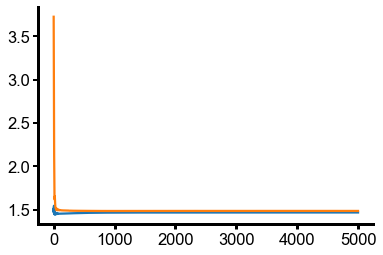

In [115]:
celln = 126

plt.plot(vloss_trace[celln])
plt.plot(GLM_VisMov_NonLinVis['vloss_trace_all'][0,mlam_NLVis[celln],celln])
vloss_trace[celln][-1],GLM_VisMov_NonLinVis['vloss_trace_all'][0,mlam_NLVis[celln],celln][-1]

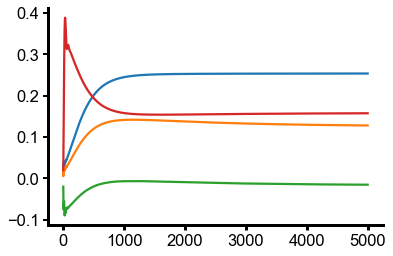

In [116]:
celln = 126
plt.plot(posNN_traces['posNN.Layer0.weight'][:,celln] + posNN_traces['posNN.Layer0.weight'][:,celln] )
# plt.plot(posNN_traces['posNN.Layer0.bias'][:,celln])


In [53]:
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), 5, 1, 12000, Kfold))
GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), params['nt_glm_lag'], 1, 5000, Kfold))
mlam_NLVis = np.nanargmin(GLM_VisMov_NonLinVis['loss_regcv'], axis=1).squeeze()


In [58]:
GLM_VisMov_Vis['pred_test'].shape,GLM_VisMov_NonLinVis['pred_test'].shape

((6698, 128), (1, 20, 128, 6698))

In [118]:
GLM_Data['pred_test'].shape

(1, 1, 128, 6698)

In [129]:
pred_test_NLVis = np.zeros((params['Ncells'],GLM_VisMov_NonLinVis['pred_test'].shape[-1]))
pred_test_Add = np.zeros((params['Ncells'],GLM_VisMov_Add['pred_test'].shape[-1]))
r2_NLVis = np.zeros((params['Ncells']))
r2_Add = np.zeros((params['Ncells']))
r2_Mul = np.zeros((params['Ncells']))

for celln in np.arange(params['Ncells']):
    pred_test_NLVis[celln] = GLM_VisMov_NonLinVis['pred_test'][0,mlam_NLVis[celln],celln]
    pred_test_Add[celln] = GLM_Data['pred_test'][0,0,celln]
    r2_NLVis[celln] = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln],celln]
    r2_Add[celln] = GLM_Data['r2_test'][0,0,celln]

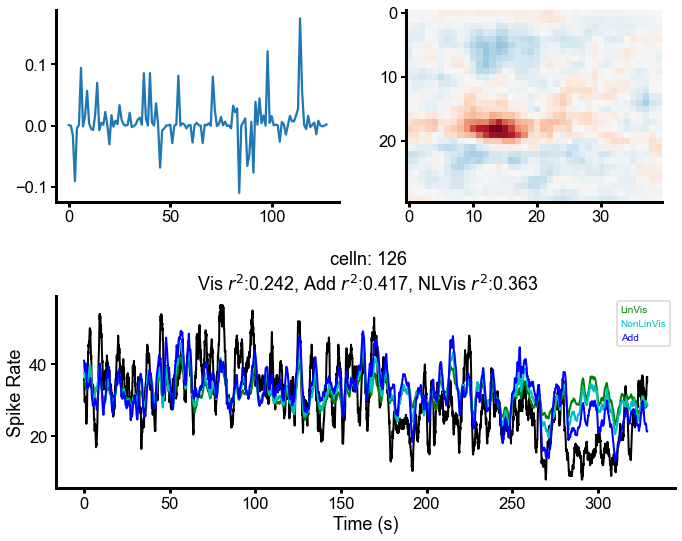

In [139]:
celln = 126
nrows = 2
fig = plt.figure(constrained_layout=False, figsize=(10,8))
spec = gridspec.GridSpec(ncols=2, nrows=nrows, figure=fig)
axs = np.array([fig.add_subplot(spec[0, n]) for n in range(nrows)])
axs2 = fig.add_subplot(spec[1, :])

ax = axs[0]
L2W = GLM_VisMov_NonLinVis['visNN']['Cell_NN.2.weight'][mlam_NLVis[celln]]
ax.plot(L2W[celln])
ax = axs[1]
crange = np.max(np.abs(GLM_VisMov_NonLinVis['sta_all'][0,mlam_NLVis[np.argmax(L2W[celln])],np.argmax(L2W[celln]),0]))
ax.imshow(GLM_VisMov_NonLinVis['sta_all'][0,mlam_NLVis[np.argmax(L2W[celln])],np.argmax(L2W[celln]),0],'RdBu_r',vmin=-crange,vmax=crange)


ax = axs2
sp_smooth_NLvis = ((np.convolve(GLM_VisMov_NonLinVis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(sp_smooth_NLvis))*params['model_dt'],sp_smooth_NLvis, 'k', lw=2)
pred_smooth_Vis = ((np.convolve(GLM_VisMov_Vis['pred_test'][:,celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_NonLinVis = ((np.convolve(GLM_VisMov_NonLinVis['pred_test'][0,mlam_NLVis[celln],celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
pred_smooth_Add = ((np.convolve(pred_test_Add[celln], np.ones(bin_length), 'same')) / (bin_length * params['model_dt']))[int(bin_length*1.5):-int(bin_length*1.5)]
ax.plot(np.arange(len(pred_smooth_Vis))*params['model_dt'],pred_smooth_Vis,'g', lw=2, label='LinVis')
ax.plot(np.arange(len(pred_smooth_NonLinVis))*params['model_dt'],pred_smooth_NonLinVis,'c', lw=2, label='NonLinVis')
ax.plot(np.arange(len(pred_smooth_Add))*params['model_dt'],pred_smooth_Add,'b', lw=2, label='Add')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Spike Rate')
ax.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
ax.set_title(' celln: {}\n Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, NLVis $r^2$:{:.03f}'.format(celln,GLM_VisMov_Vis['r2_test'][celln],r2_Add[celln],r2_NLVis[celln]))

plt.tight_layout()

## Comparison of all models

In [148]:
Kfold = 0
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), 5, 1, 12000, Kfold))
GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), 5, 1, 5000, Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis_Add', int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis_Mul', int(params['model_dt']*1000), params['nt_glm_lag'], 2, 5000, Kfold))
mlam_NLVis = np.nanargmin(GLM_VisMov_NonLinVis['loss_regcv'], axis=1).squeeze()
mlam_Add = np.nanargmin(GLM_VisMov_Add['loss_regcv'], axis=1).squeeze()
mlam_Mul = np.nanargmin(GLM_VisMov_Mul['loss_regcv'], axis=1).squeeze()

In [149]:
pred_test_NLVis = np.zeros((params['Ncells'],GLM_VisMov_NonLinVis['pred_test'].shape[-1]))
pred_test_Add = np.zeros((params['Ncells'],GLM_VisMov_Add['pred_test'].shape[-1]))
pred_test_Mul = np.zeros((params['Ncells'],GLM_VisMov_Mul['pred_test'].shape[-1]))
r2_NLVis = np.zeros((params['Ncells']))
r2_Add = np.zeros((params['Ncells']))
r2_Mul = np.zeros((params['Ncells']))

for celln in np.arange(params['Ncells']):
    pred_test_NLVis[celln] = GLM_VisMov_NonLinVis['pred_test'][0,mlam_NLVis[celln],celln]
    pred_test_Add[celln] = GLM_VisMov_Add['pred_test'][0,mlam_NLVis[celln],celln]
    pred_test_Mul[celln] = GLM_VisMov_Mul['pred_test'][0,mlam_NLVis[celln],celln]
    r2_NLVis[celln] = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln],celln]
    r2_Add[celln] = GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln],celln]
    r2_Mul[celln] = GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln],celln]

In [125]:
mlam_NLVis = np.nanargmin(GLM_VisMov_NonLinVis['loss_regcv'], axis=1).squeeze()
mlam_Add = np.nanargmin(GLM_VisMov_Add['loss_regcv'], axis=1).squeeze()
mlam_Mul = np.nanargmin(GLM_VisMov_Mul['loss_regcv'], axis=1).squeeze()

In [161]:

GLM_VisMov_Add['visNN']['posNN.Layer0.bias'][mlam_Add[celln],celln],GLM_VisMov_Mul['visNN']['posNN.Layer0.bias'][mlam_Mul[celln],celln]

(1.9313223, 1.045124)

In [ ]:
GLM_VisMov_Add['pred_test'].shape,GLM_VisMov_Mul['pred_test'].shape,

((1, 20, 128, 6698), (1, 20, 128, 6698))

Done Loading Unaligned data


  0%|          | 0/10 [00:00<?, ?it/s]

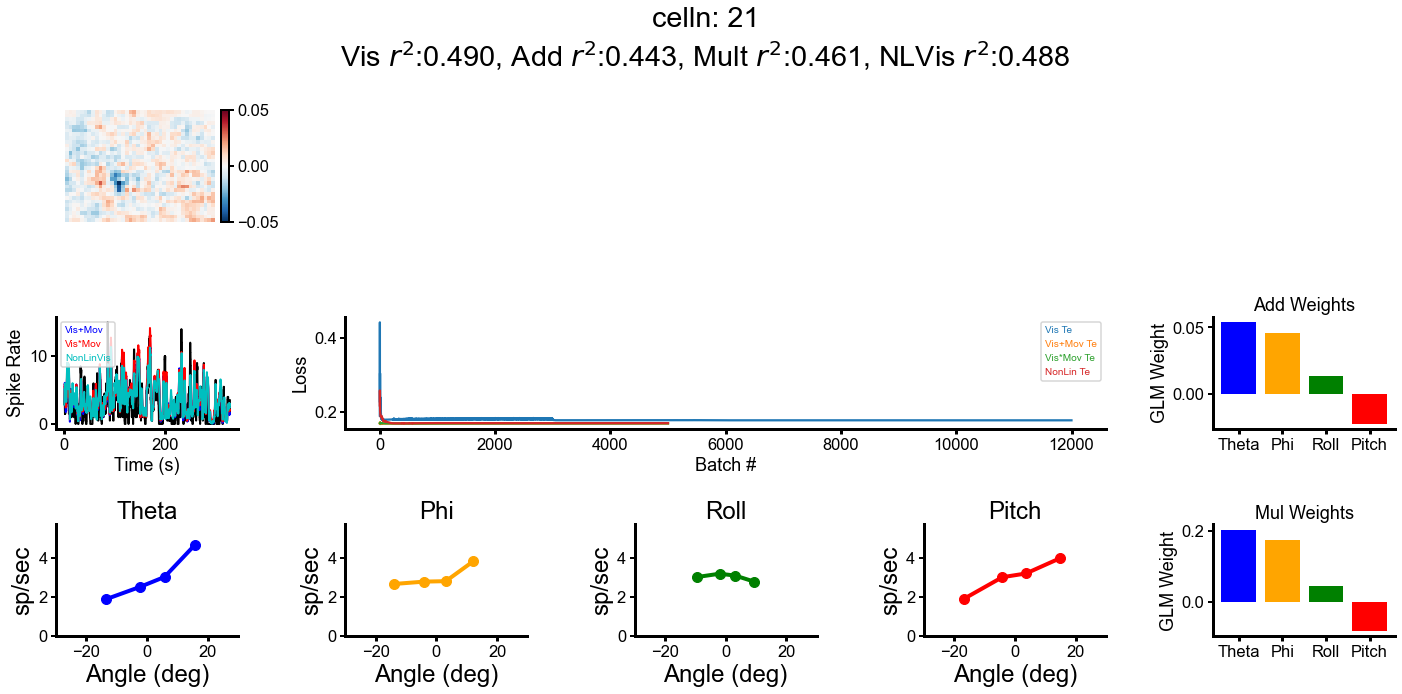

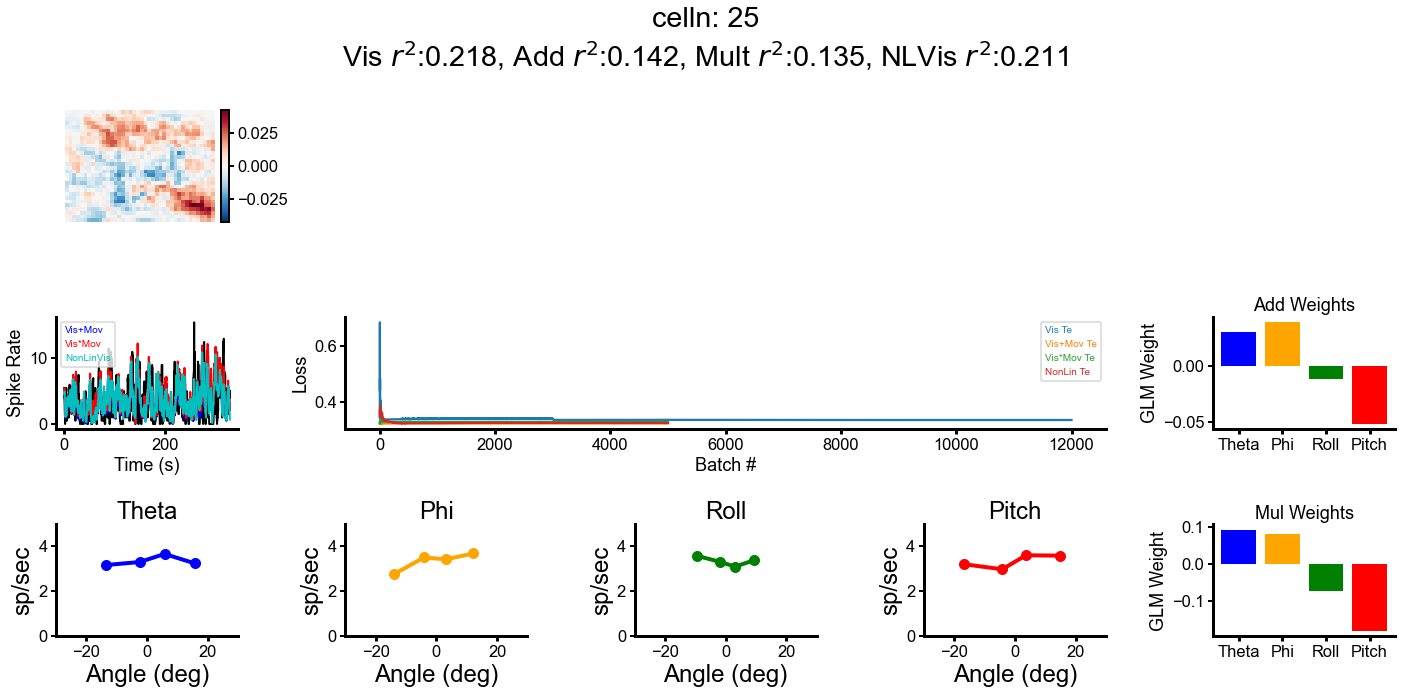

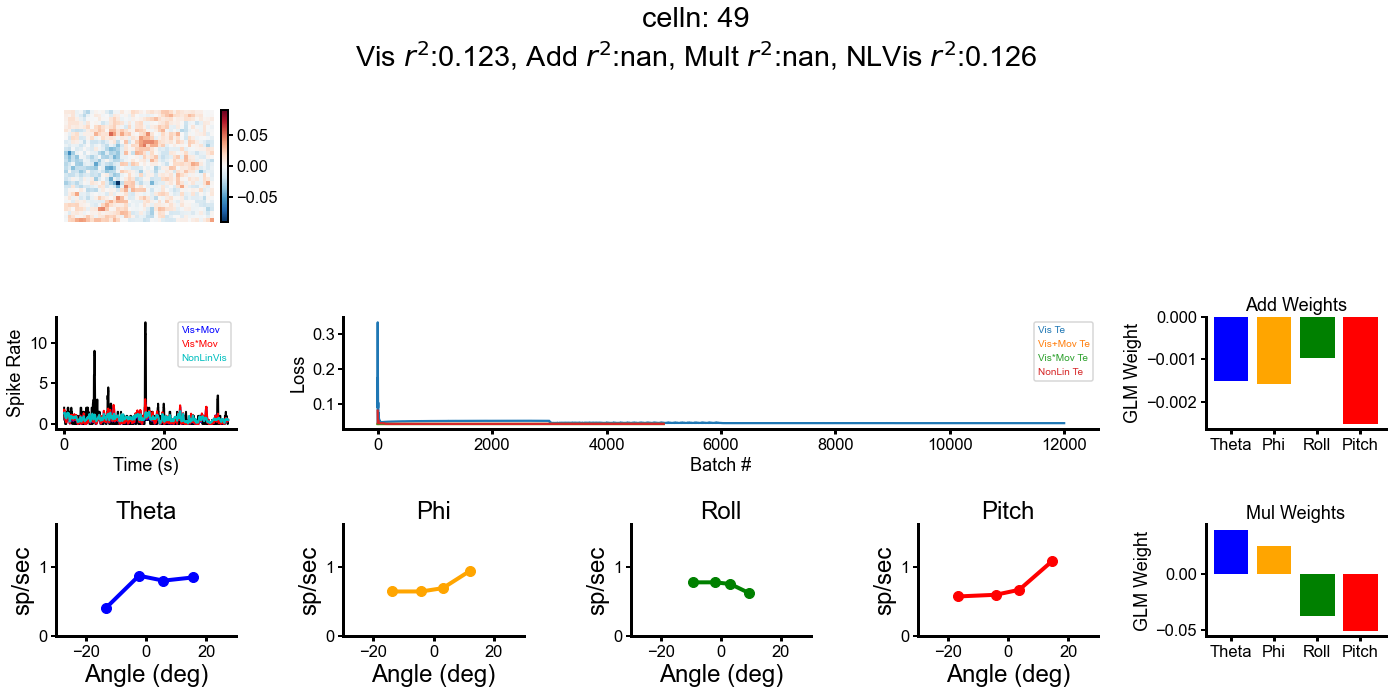

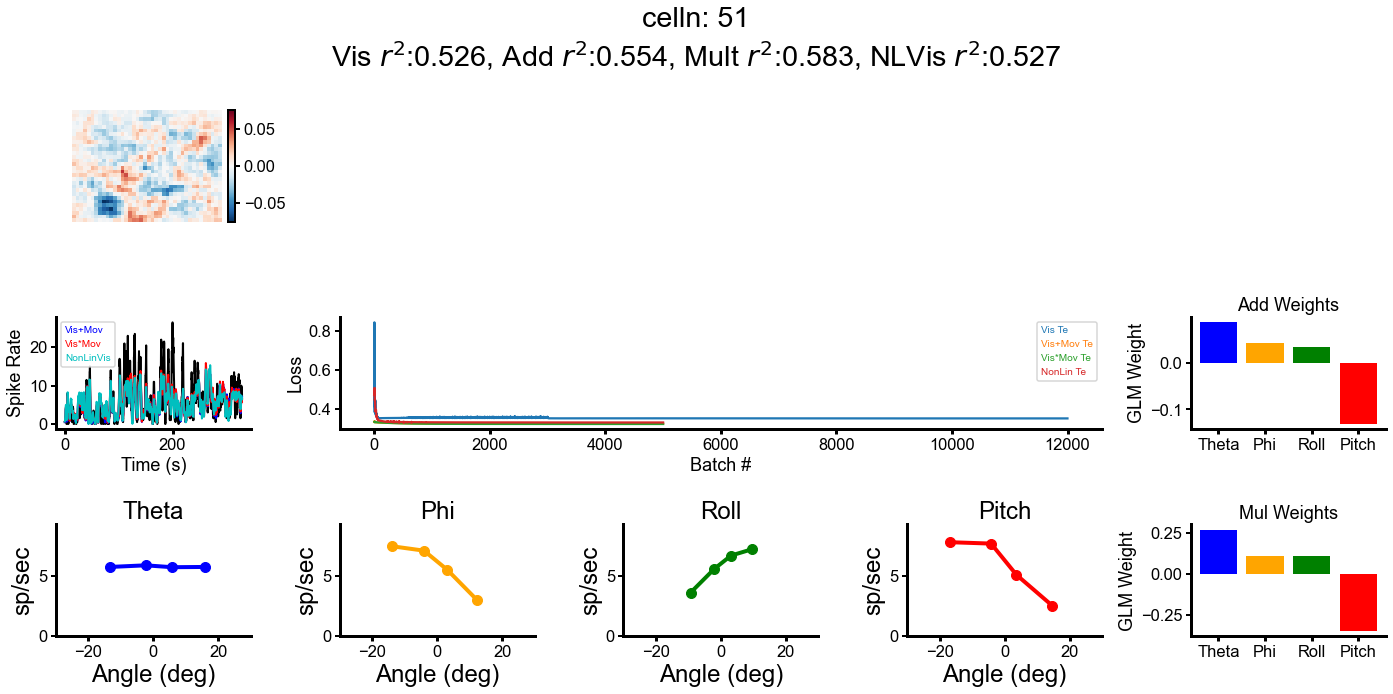

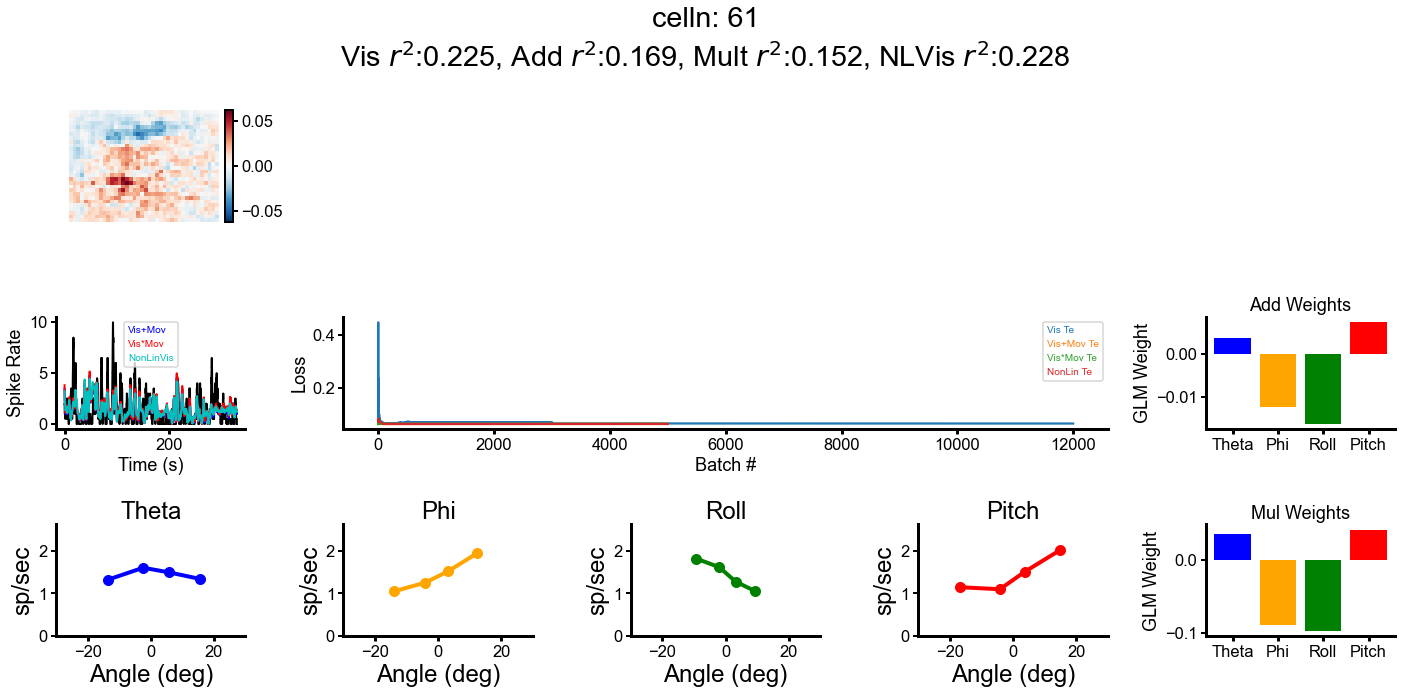

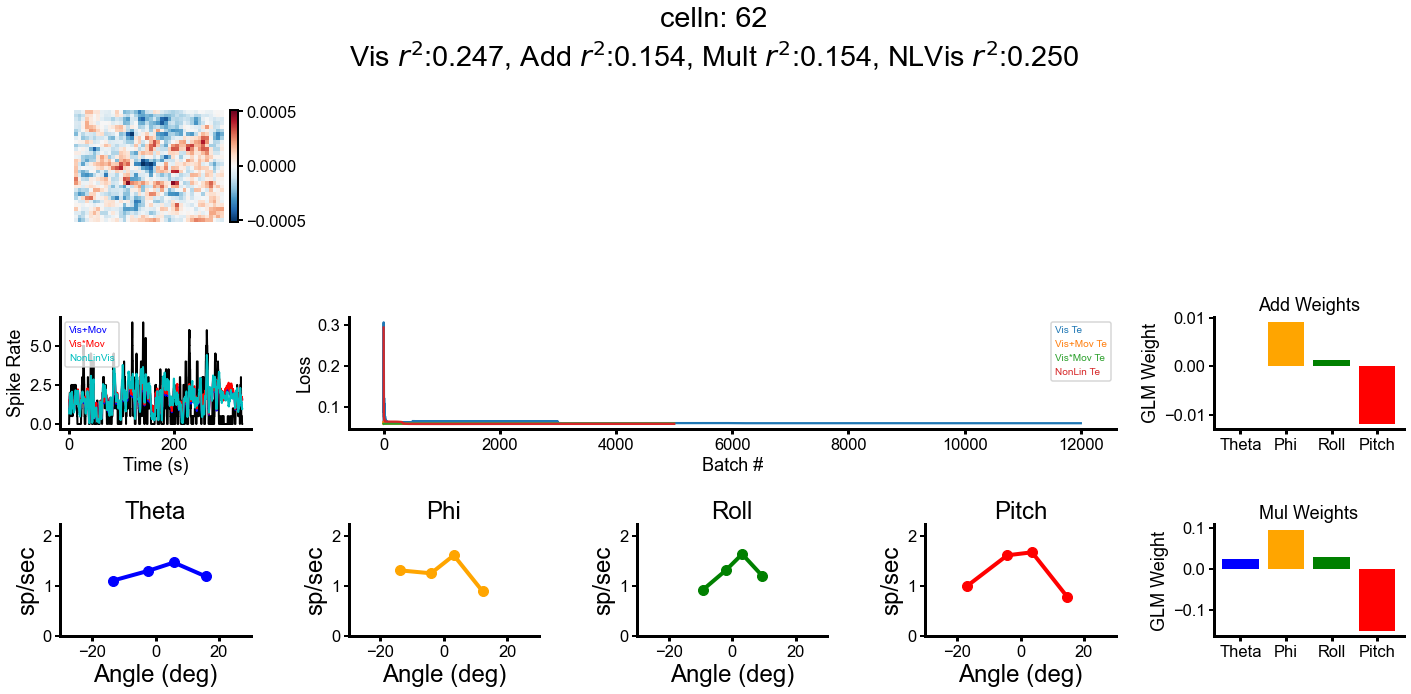

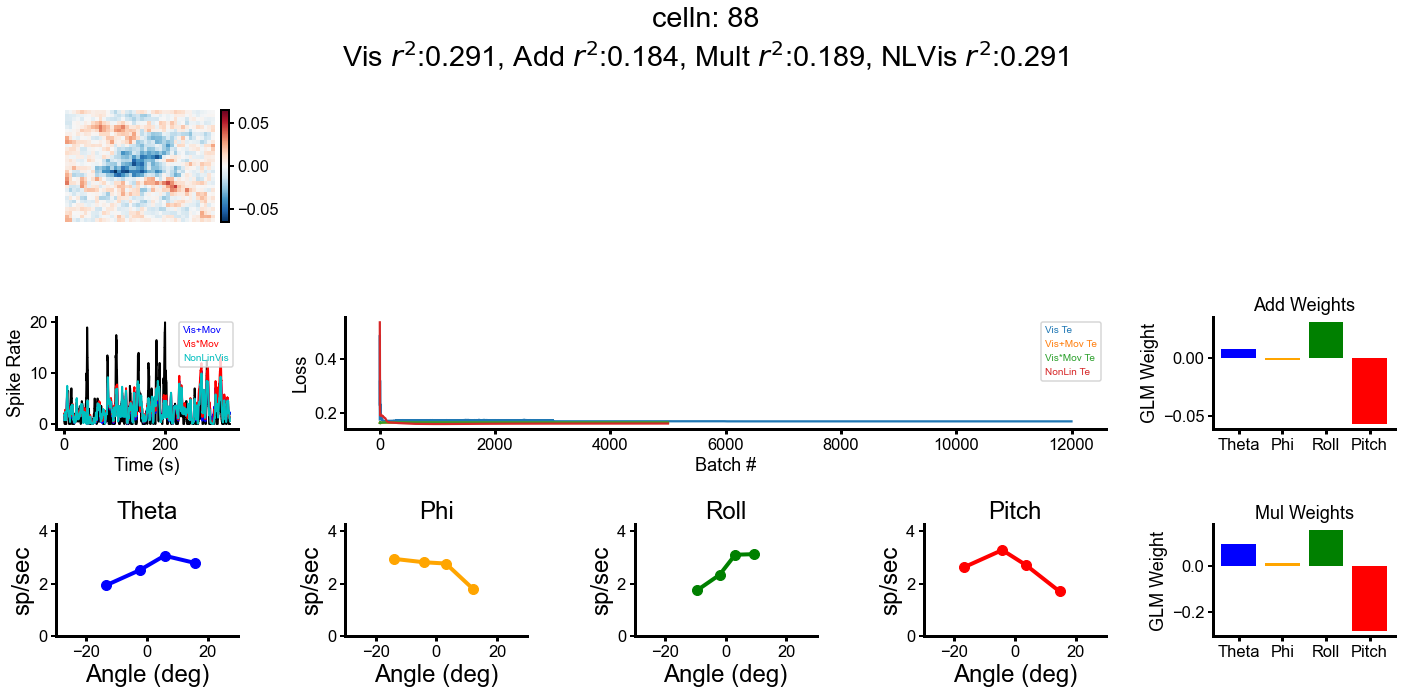

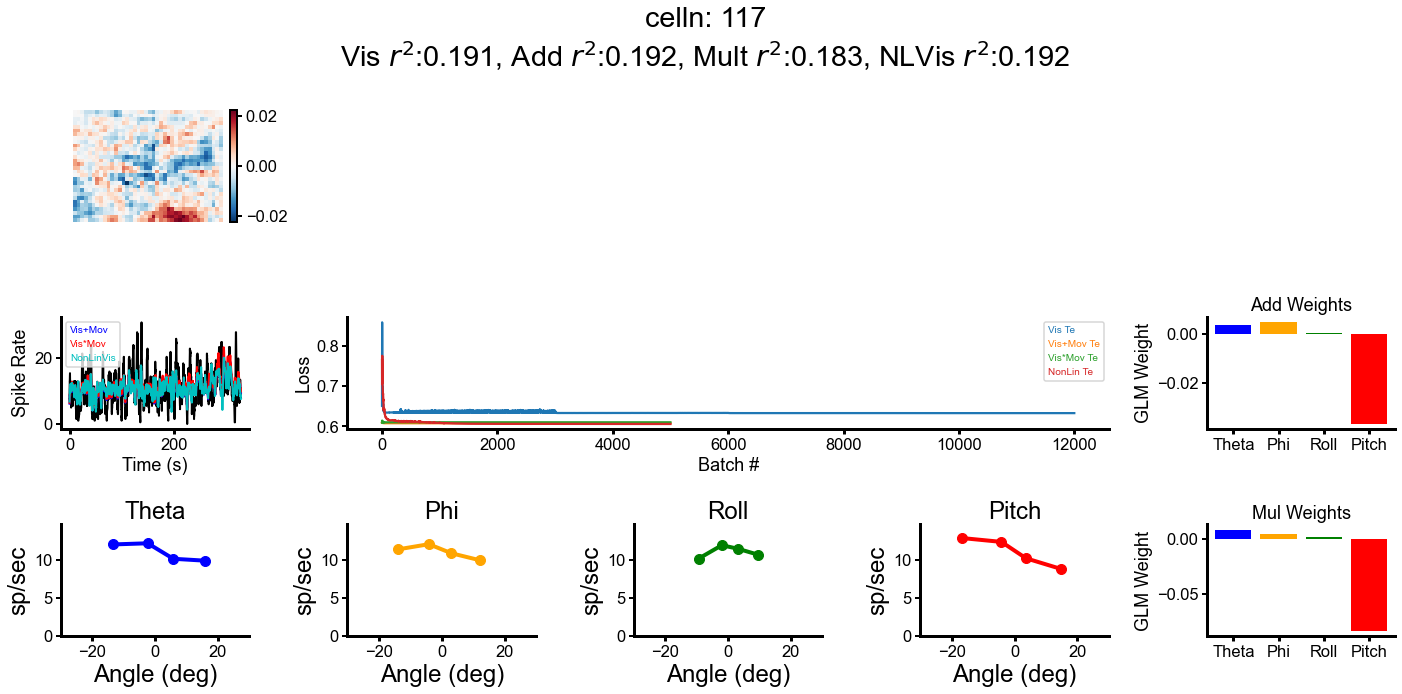

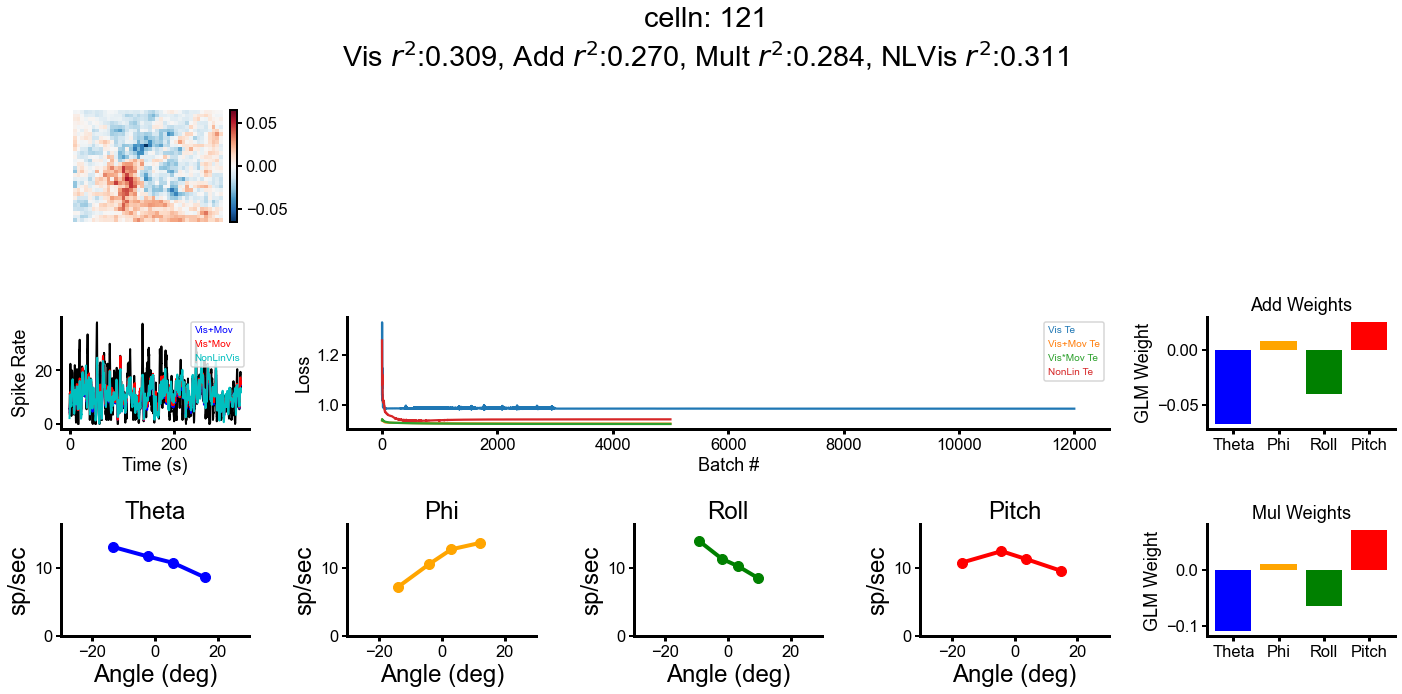

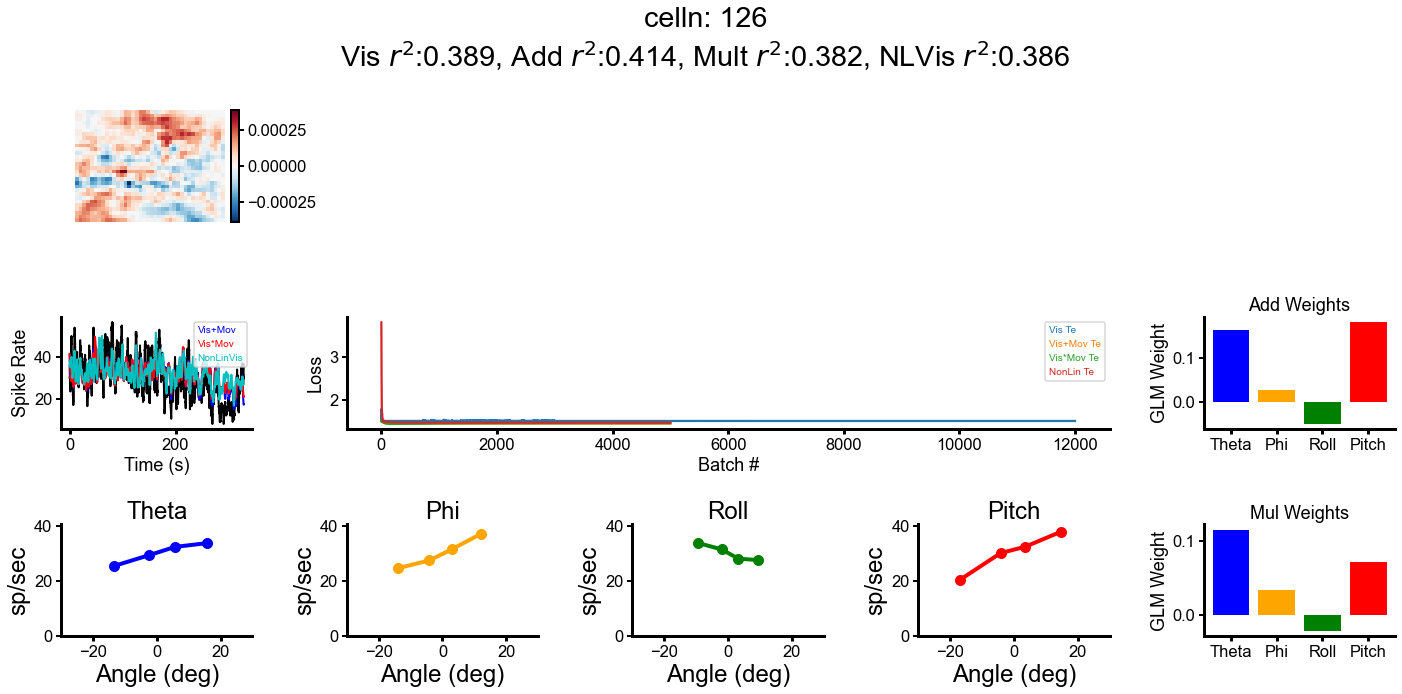

In [151]:
save_pdf = False

ncells = data['model_nsp'].shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)
spk_percentile2 = np.arange(.125,1.125,.25)

fontsize = 24
Kfold = 0
Nepochs = 5000
move_train,mov_test,model_move,nsp_raw,move_data,tuning_curves,tuning_stds,tuning_curve_edges,ax_ylims,tc_mod,avg_fr,tuning_sig,tuning_sig2,tuning_idx=load_Kfold_forPlots(params, Kfold=Kfold, dataset_type='test')
GLM_VisMov_Vis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_Vis',int(params['model_dt']*1000), 5, 1, 12000, Kfold))
GLM_VisMov_NonLinVis = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis', int(params['model_dt']*1000), 5, 1, 5000, Kfold))
GLM_VisMov_Add = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis_Add', int(params['model_dt']*1000), params['nt_glm_lag'], 2, params['Nepochs'], Kfold))
GLM_VisMov_Mul = ioh5.load(save_dir/'GLM_{}_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_NB{}_Kfold{:02d}.h5'.format('Pytorch_NonLinVis_Mul', int(params['model_dt']*1000), params['nt_glm_lag'], 2, params['Nepochs'], Kfold))
mlam_NLVis = np.nanargmin(GLM_VisMov_NonLinVis['loss_regcv'], axis=1).squeeze()
mlam_Add = np.nanargmin(GLM_VisMov_Add['loss_regcv'], axis=1).squeeze()
mlam_Mul = np.nanargmin(GLM_VisMov_Mul['loss_regcv'], axis=1).squeeze()
pred_test_NLVis = np.zeros((params['Ncells'],GLM_VisMov_NonLinVis['pred_test'].shape[-1]))
pred_test_Add = np.zeros((params['Ncells'],GLM_VisMov_Add['pred_test'].shape[-1]))
pred_test_Mul = np.zeros((params['Ncells'],GLM_VisMov_Mul['pred_test'].shape[-1]))
r2_NLVis = np.zeros((params['Ncells']))
r2_Add = np.zeros((params['Ncells']))
r2_Mul = np.zeros((params['Ncells']))

for celln in np.arange(params['Ncells']):
    pred_test_NLVis[celln] = GLM_VisMov_NonLinVis['pred_test'][0,mlam_NLVis[celln],celln]
    pred_test_Add[celln] = GLM_VisMov_Add['pred_test'][0,mlam_Add[celln],celln]
    pred_test_Mul[celln] = GLM_VisMov_Mul['pred_test'][0,mlam_Mul[celln],celln]
    r2_NLVis[celln] = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln],celln]
    r2_Add[celln] = GLM_VisMov_Add['r2_test'][0,mlam_Add[celln],celln]
    r2_Mul[celln] = GLM_VisMov_Mul['r2_test'][0,mlam_Mul[celln],celln]
locals().update(params)

pbar = tqdm([21,25,49,51,61,62,88,117,121,126]) # [12,13,20,25,49,51]) # 
# pbar = tqdm(np.arange(model_nsp.shape[-1]))
pdf_name = fig_dir/ 'VisMov_{}_dt{:03d}_Lags{:02d}_Kfold{:02d}_CellSummary.pdf'.format('Pytorch_VisMov_AddMul',int(params['model_dt']*1000),params['nt_glm_lag'],Kfold)
if save_pdf:
    pdf = PdfPages(pdf_name)
for n, celln in enumerate(pbar): 
    fig2 = plt.figure(constrained_layout=False, figsize=(20,10))
    spec2 = gridspec.GridSpec(ncols=5, nrows=3, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(params['nt_glm_lag'])])
    axs3a = np.array([fig2.add_subplot(spec2[2, n]) for n in range(len(titles))])
    f2_ax6 = fig2.add_subplot(spec2[1, :params['nt_glm_lag']//2+1])
    f2_ax7 = fig2.add_subplot(spec2[1, (params['nt_glm_lag']//2+1):-1])
    f2_ax8 = fig2.add_subplot(spec2[1,-1])
    f2_ax8b = fig2.add_subplot(spec2[2,-1])
    if MovModel != 0:
        crange = np.max(np.abs(GLM_VisMov_Add['sta_all'][0,mlam_Add[celln],celln]))
        crange2 = np.max(np.abs(GLM_VisMov_Mul['sta_all'][0,mlam_Mul[celln],celln]))
        for m,ax in enumerate(axs):
            im = ax.imshow(GLM_VisMov_Add['sta_all'][0,mlam_Add[celln],celln,m],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

    sp_smooth_vis = ((np.convolve(GLM_VisMov_Vis['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    sp_smooth_NLvis = ((np.convolve(GLM_VisMov_Add['test_nsp'][:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    f2_ax6.plot(np.arange(len(sp_smooth_vis))*model_dt,sp_smooth_vis, 'k', lw=2)
    pred_smooth_Vis = ((np.convolve(pred_test_NLVis[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Add = ((np.convolve(pred_test_Add[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_Mul = ((np.convolve(pred_test_Mul[celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    pred_smooth_NonLinVis = ((np.convolve(GLM_VisMov_NonLinVis['pred_test'][0,mlam_NLVis[celln],celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[int(bin_length*1.5):-int(bin_length*1.5)]
    # f2_ax6.plot(np.arange(len(pred_smooth_Vis))*model_dt,pred_smooth_Vis,'g', lw=2,label='Vis')
    f2_ax6.plot(np.arange(len(pred_smooth_Add))*model_dt,pred_smooth_Add,'b', lw=2, label='Vis+Mov')
    f2_ax6.plot(np.arange(len(pred_smooth_Mul))*model_dt,pred_smooth_Mul,'r', lw=2, label='Vis*Mov')
    f2_ax6.plot(np.arange(len(pred_smooth_NonLinVis))*model_dt,pred_smooth_NonLinVis,'c', lw=2, label='NonLinVis')
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax6.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0)
    r2_Vis = (np.corrcoef(sp_smooth_vis,pred_smooth_Vis)[0,1])**2
    r2_Mul = GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln],celln] #(np.corrcoef(sp_smooth_NLvis,pred_smooth_Mul)[0,1])**2
    r2_Add = GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln],celln] #(np.corrcoef(sp_smooth_NLvis,pred_smooth_Add)[0,1])**2
    r2_AddMul = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln],celln]# (np.corrcoef(sp_smooth_NLvis,pred_smooth_NonLinVis)[0,1])**2
    


    # f2_ax7.plot(GLM_VisMov_Vis['tloss_trace_all'][celln],label='Vis Tr')
    # f2_ax7.plot(GLM_VisMov_Add['tloss_trace_all'][celln],label='Vis+Mov Tr')
    # f2_ax7.plot(GLM_VisMov_Mul['tloss_trace_all'][celln],label='Vis*Mov Tr')
    f2_ax7.plot(GLM_VisMov_Vis['vloss_trace_all'][celln], label='Vis Te')
    f2_ax7.plot(GLM_VisMov_Add['vloss_trace_all'][0,mlam_Add[celln],celln], label='Vis+Mov Te')
    f2_ax7.plot(GLM_VisMov_Mul['vloss_trace_all'][0,mlam_Mul[celln],celln], label='Vis*Mov Te')
    f2_ax7.plot(GLM_VisMov_NonLinVis['vloss_trace_all'][0,mlam_NLVis[celln],celln], label='NonLin Te')
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    f2_ax7.legend(labelcolor='linecolor', fontsize=10, handlelength=0, handletextpad=0, fancybox=True)

    w_move_Add = GLM_VisMov_Add['visNN']['posNN.Layer0.weight'][mlam_Add[celln]]
    w_move_Mov = GLM_VisMov_Mul['visNN']['posNN.Layer0.weight'][mlam_Mul[celln]]
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move_Add[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')
        f2_ax8.set_title('Add Weights')
        f2_ax8b.bar(modeln, w_move_Mov[celln,modeln], color=clrs[modeln])
        f2_ax8b.set_xticks(np.arange(0,len(titles)))
        f2_ax8b.set_xticklabels(titles)
        f2_ax8b.set_ylabel('GLM Weight')
        f2_ax8b.set_title('Mul Weights')


    top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
    for i,modeln in enumerate(range(len(titles))):
        metric = move_data[:,modeln]
        nranges = np.quantile(metric,quartiles)
        stat_range, edges, _ = binned_statistic(metric,nsp_raw[:,celln],statistic='mean',bins=nranges)
        edge_mids = np.quantile(metric,spk_percentile2)#
        # for m in range(len(nranges)-1):
        #     axs[0,modeln].axvspan(nranges[m], nranges[m+1],ymin=0,ymax=1,alpha=0.8, color=colors[m],zorder=0)
        axs3a[modeln].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

        axs3a[modeln].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
        axs3a[modeln].set_xlim(-30,30)
        axs3a[modeln].set_xlabel('Angle (deg)',fontsize=fontsize)
        axs3a[modeln].set_ylabel('sp/sec',fontsize=fontsize)
        axs3a[modeln].set_title(titles[modeln],fontsize=fontsize)

    plt.suptitle(' celln: {}\n Vis $r^2$:{:.03f}, Add $r^2$:{:.03f}, Mult $r^2$:{:.03f}, NLVis $r^2$:{:.03f}'.format(celln,r2_Vis,r2_Add,r2_Mul,r2_AddMul))
    plt.tight_layout()
    if save_pdf:
        pdf.savefig()
        plt.close()
if save_pdf:
    pdf.close()


In [ ]:
pdf.close()


## Scatter Plots

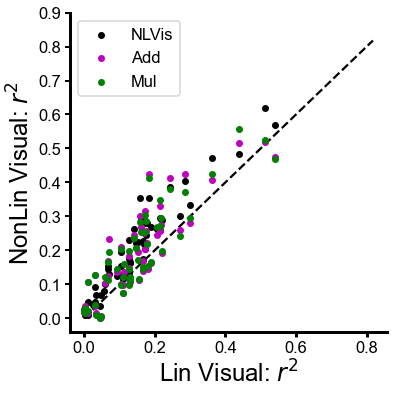

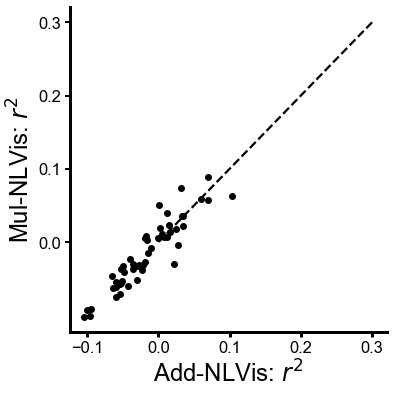

In [187]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40
fig, ax = plt.subplots(figsize=(6,6))
xvals = GLM_VisMov_Vis['r2_test'][tuning_sig2] #[tuning_sig2] # GLM_VisMov_Mot['r2_test'][tuning_sig2]
yvals = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln]][tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals_add = GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln]][tuning_sig2]
yvals_mul = GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln]][tuning_sig2]

# yvals2 = r2_Add#[tuning_sig2]
# yvals3 = np.nanmean(r2_AddMul,axis=0)[tuning_sig2]
tuning_idx = np.where(tuning_sig2)[0]
lim_max = np.nanmax((xvals,yvals))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((xvals,yvals))-1.5*np.nanstd((xvals,yvals))
lims = (0, lim_max)
ax.scatter(xvals,yvals,30,c='k', label='NLVis')
ax.scatter(xvals,yvals_add,30,c='m', label='Add')
ax.scatter(xvals,yvals_mul,30,c='g', label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Lin Visual: $r^2$',fontsize=fontsize)
ax.set_ylabel('NonLin Visual: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=1))
leg = ax.legend()
# for handle, text in zip(leg.legendHandles, leg.get_texts()):
#     text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(fig_dir/'NonLinVis_Vs_LinVis{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')
####################################


yvals_add = (GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln]][tuning_sig2] - yvals)
yvals_mul = (GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln]][tuning_sig2] - yvals)
lim_max = np.nanmax((yvals_add,yvals_mul))+1.5*np.nanstd((xvals,yvals))
lim_min = np.nanmin((yvals_add,yvals_mul))-1.5*np.nanstd((xvals,yvals))
lims = (0, lim_max)
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(yvals_add,yvals_mul,30,c='k')
# ax.scatter(xvals,yvals_add,30,c='m', label='Add')
# ax.scatter(xvals,yvals_mul,30,c='g', label='Mul')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.set_xlabel('Add-NLVis: $r^2$',fontsize=fontsize)
ax.set_ylabel('Mul-NLVis: $r^2$',fontsize=fontsize)
ax.set_yticks(np.arange(0,lims[1],.1))
ax.set_yticklabels(np.round(np.arange(0,lims[1],.1),decimals=1))
# leg = ax.legend()
# for handle, text in zip(leg.legendHandles, leg.get_texts()):
#     text.set_color(handle.get_facecolor()[0])
# ax.legend(labelcolor='facecolor', fontsize=18, handlelength=0, handletextpad=0, fancybox=True)
# ax.set_title('FR Thresh={}, Tuning Thresh={} \n bin_len: {}'.format(thresh_fr,tuning_thresh,bin_length))
# for i, txt in enumerate(np.arange(len(xvals))):
#     ax.annotate(tuning_idx[i], (xvals[i], yvals[i]),fontsize=10)
plt.tight_layout()
# fig.savefig(fig_dir/'NL_AddMUL{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')



ValueError: x and y must be the same size

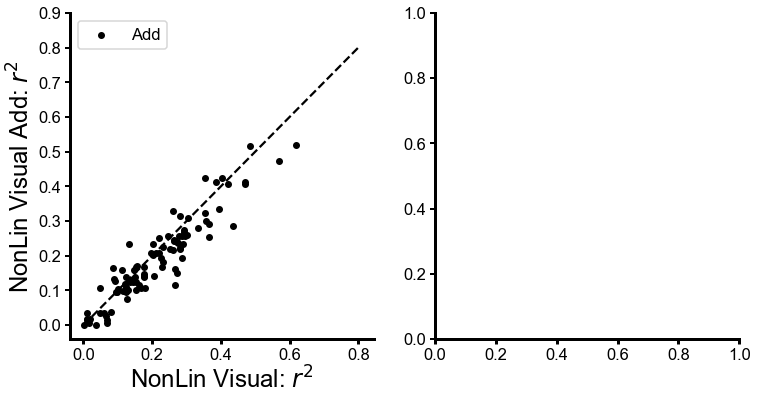

In [188]:
a = 0; l = 0
thresh_fr = 1
tuning_thresh = .2
fontsize=24
bin_length=40
fig, axs = plt.subplots(1,2,figsize=(12,6))
# xvals = GLM_VisMov_Vis['r2_test']#[tuning_sig2]  # GLM_VisMov_Mot['r2_test'][tuning_sig2]
xvals = GLM_VisMov_NonLinVis['r2_test'][0,mlam_NLVis[celln]]#[tuning_sig2] # GLM_VisMov_Vis['r2_test'][tuning_sig2]
yvals_add = GLM_VisMov_Add['r2_test'][0,mlam_NLVis[celln]]#[tuning_sig2]
# yvals_mul = GLM_VisMov_Mul['r2_test'][0,mlam_NLVis[celln]]#[tuning_sig2]

lim_max = np.nanmax((xvals,yvals_add))+1.5*np.nanstd((xvals,yvals_add))
lim_min = np.nanmin((xvals,yvals_add))-1.5*np.nanstd((xvals,yvals_add))
lims = (0, lim_max)
axs[0].scatter(xvals,yvals_add,30,c='k', label='Add')

axs[0].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
axs[0].set_xlabel('NonLin Visual: $r^2$',fontsize=fontsize)
axs[0].set_ylabel('NonLin Visual Add: $r^2$',fontsize=fontsize)
axs[0].set_yticks(np.arange(0,1,.1))
axs[0].set_yticklabels(np.round(np.arange(0,1,.1),decimals=1))
leg = axs[0].legend()


axs[1].scatter(xvals,yvals_mul,30,c='k', label='Mul')
axs[1].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
axs[1].set_xlabel('NonLin Visual: $r^2$',fontsize=fontsize)
axs[1].set_ylabel('NonLin Visual Mul: $r^2$',fontsize=fontsize)
axs[1].set_yticks(np.arange(0,1,.1))
axs[1].set_yticklabels(np.round(np.arange(0,1,.1),decimals=1))
leg = axs[1].legend()
fig.savefig(fig_dir/'NL_AddMUL_Comparison{}_Kfold{:02d}.png'.format(bin_length,Kfold), facecolor='white', transparent=True, bbox_inches='tight')


In [153]:
data2 = ioh5.load('/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/ModelData_dt025_rawWorldCam.h5')

In [154]:
data2['mod_vid_sm_shift'].shape

(108707, 60, 80)

In [157]:
data2['mod_vid_sm_shift'][0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.8770151 , -0.8328559 , -0.8508214 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.77711225, -0.62009984, -0.7261356 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54378843, -0.44601423, -0.64004976, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [171]:
avgfm_eye = np.load(params['save_dir_fm']/'FM_AvgEye_dt{:03d}.npy'.format(int(params['model_dt']*1000)))
model_move = np.hstack((data2['model_th'][:, np.newaxis]-avgfm_eye[0], data2['model_phi'][:, np.newaxis]-avgfm_eye[1],data2['model_roll'][:, np.newaxis], data2['model_pitch'][:, np.newaxis]))

In [176]:
df = pd.DataFrame(model_move,columns=titles)

In [182]:
df2 = df.interpolate(method='linear')

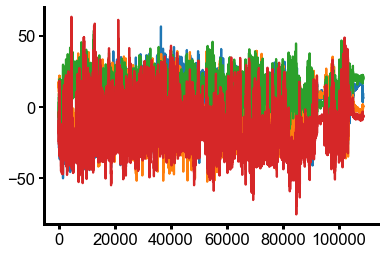

In [186]:
plt.plot(df2)

6000 to 4 per unit to 128 units